# **How Fast Delivery Builds Trust: E-Commerce Data Analysis**
An analysis of Brazillian E-Commerce transactions made at [Olist Store](www.olist.com).

**Created By:** *Fritz Immanuel & Gerard Louis Howan* (JCDS 2502)

### **Import Libraries & Dataset**

In [1]:
# standard DA libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# map
import folium

# text processing
import nltk
import re
import string
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from googletrans import Translator
from num2words import num2words
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) # display all columns, without limits
pd.set_option('display.max_colwidth', None)

In [2]:
# load dataset
customers_df = pd.read_csv('dataset/raw/olist_customers_dataset.csv')

orders_df = pd.read_csv('dataset/raw/olist_orders_dataset.csv')
order_items_df = pd.read_csv('dataset/raw/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('dataset/raw/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('dataset/raw/olist_order_reviews_dataset.csv')

products_df = pd.read_csv('dataset/raw/olist_products_dataset.csv')
pcateg_translation_df = pd.read_csv('dataset/raw/product_category_name_translation.csv')

sellers_df = pd.read_csv('dataset/raw/olist_sellers_dataset.csv')

geolocation_df = pd.read_csv('dataset/raw/olist_geolocation_dataset.csv')

## **> Introduction**

<hr>

### **Business Context**

[Olist](https://www.olist.com) is a Brazilian e-commerce enabler that helps small and medium-sized businesses sell through major marketplaces like Amazon, Magalu, and Mercado Libre. By consolidating key services — from logistics to customer management — Olist allows sellers to focus on sales while scaling more efficiently.

As the platform grows, a critical issue emerges: **seller churn**. When sellers become inactive, the platform loses not just revenue, but also product diversity and competitive edge. These sellers often leave quietly, without formally deactivating, making churn difficult to detect and costly to recover from.

Unlike buyer churn, **seller churn has deeper operational implications**. A drop in active sellers affects buyer experience, fulfillment speed, and overall marketplace health. To stay ahead, Olist must not only detect churn, but understand the **patterns that precede it** — and act early.

### **Business Problem**

Olist aims to proactively **identify sellers at risk of churn** — those who are silently becoming inactive, based on transaction behavior and engagement patterns. By understanding why sellers disengage, we can:

* **Re-engage at-risk sellers** before they drop off
* Detect operational or product issues tied to churn
* Forecast future seller supply and revenue more accurately
* Reduce losses tied to declining seller participation

### **Project Objective**

Build a **binary classification model** to predict whether a seller is **churned** (`1`) or **active** (`0`), using only historical transaction and behavioral data.

#### **Target Definition:**

* `1 = Churned`: No orders in the last **X days**
* `0 = Active`: Has placed an order in the last **X days**

> *Note: The specific definition of “churn” will be **empirically determined** based on activity gaps in the dataset.*

### **Key Questions**

1. **What is the typical lifecycle of a seller on Olist?**
2. **Are there behavioral signals — like order frequency, delay, or price — that precede churn?**
3. **Does churn differ by product category, review score, or payment behavior?**
4. **Can we build a predictive model that effectively flags sellers before they churn?**
5. **Which features most strongly influence churn, and how can Olist act on them?**

### **Analytical Approach**

1. **Exploratory Analysis**

   * Study seller order timelines, retention patterns, and engagement decay
   * Investigate variables like review scores, delivery delays, pricing, and categories

2. **Define Churn Label**

   * Use provided data to determin label churned vs active sellers

3. **Feature Engineering**

   * Include seller lifecycle stats, delivery metrics, review distributions, product diversity, price behavior, payment structure, and cohort indicators

4. **Modeling**

   * Compare multiple classifiers: Logistic Regression, Decision Trees, Random Forest, AdaBoost, Gradient Boosting, XGBoost
   * Evaluate both with and without resampling

5. **Evaluation**

   * Use **F2 Score** to prioritize recall (catching churners) over precision
   * Validate with cross-validation and stratified sampling

6. **Interpretation**

   * Use **SHAP values** and feature importance to explain the model
   * Summarize key churn signals to inform action

### **Metric Strategy**

We selected the **F2 Score** as the core evaluation metric to **prioritize recall** — catching churned sellers, even if it means allowing more false positives. For Olist, **missing a true churner is more costly** than mistakenly flagging an active seller.

### **Expected Outcomes**

* A validated **churn label definition** based on inactivity logic
* A trained, interpretable model for **predicting seller churn**
* Key feature insights (e.g., early momentum, delivery issues, price strategies)
* A consolidated dataset ready for deployment or scoring
* Actionable recommendations for **intervention and retention strategy**

## **> Data Understanding & Cleaning**
<hr>

### **Function Library**

In [3]:
def pltFigsize(size: tuple):
  plt.figure(figsize=size)

In [4]:
def pltTitle(title: str):
  plt.title(
    title,
    fontdict={
      'fontsize': 16,
      'fontweight' : 'bold',
    }
  )

In [5]:
def showBoxPlot(source, col_x: str, x_axis_label: str):
  sns.boxplot(source, x=col_x)

  pltTitle(f'Distribution of {x_axis_label}')

  plt.xlabel(x_axis_label)

In [6]:
def showHistplot(source, col_x: str, x_axis_label: str):
  sns.histplot(source, x=col_x, kde=True)

  pltTitle(f'Frequency Distribution of {x_axis_label}')

  plt.xlabel(x_axis_label)

In [7]:
def showDistributionCombo(source, col_x: str, x_axis_label: str):
  pltFigsize((20,5))

  plt.subplot(1,2,1)
  showBoxPlot(source,  col_x, x_axis_label)

  plt.subplot(1,2,2)
  showHistplot(source,  col_x, x_axis_label)

  plt.show()

In [8]:
def showUniqueValues(source, limit: int):
	listItem = []
	for col in source.columns :
		listItem.append([col, source[col].nunique(), source[col].sort_values().unique()])

	df_uniques_per_column = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'], data=listItem)

	if limit > 0:
		return df_uniques_per_column[df_uniques_per_column['Number of Unique']<=limit].sort_values('Number of Unique', ascending=False)
	else:
		return df_uniques_per_column.sort_values('Number of Unique', ascending=False)

### **Customers Dataset**

some descriptive text here

**`olist_customers_dataset.csv` (99,441 rows)**

| Column Name                | Data Type | Description                                                 |
| -------------------------- | --------- | ----------------------------------------------------------- |
| `customer_id`              | `object`/`string`  | Unique identifier for each customer.                        |
| `customer_unique_id`       | `object`/`string`  | Unique identifier for each customer across multiple orders. |
| `customer_zip_code_prefix` | `int64`   | First five digits of the customer's zip code.               |
| `customer_city`            | `object`/`string`  | City where the customer is located.                         |
| `customer_state`           | `object`/`string`  | State where the customer is located.                        |

#### Unique Values

In [9]:
showUniqueValues(customers_df, 14994) # add limit to remove '_id's from the list, as it is not important here

Column Name  Number of Unique  \
2  customer_zip_code_prefix             14994   
3             customer_city              4119   
4            customer_state                27   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Unique Sample  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [1003, 1004, 1005, 1006, 1007, 1008, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1030, 1031, 1032, 1033, 1035, 1036, 1037, 1038, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1102, 1103, 1105, 1106, 1107, 1108, 1120, 1121, 1122, 1123, 1124, 1125, 1127, 1129, 1131, 1132, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1144, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, ...]  
3  [abadia dos dourados, abadiania, abaete, abaetetuba, abaiara, abaira, abare, abatia, abdon batista, abelardo luz, abrantes, abre campo, abreu e lima, acaiaca, acailandia, acajutiba, acarau, acari, acegua, acopiara, acreuna, acu, acucena, adamantina, adhemar de barros, adolfo, adrianopolis, adustina, afogados da ingazeira, afonso claudio, afranio, agisse, agrestina, agrolandia, agronomica, agua boa, agua branca, agua clara, agua comprida, agua doce, agua doce do norte, agua fria de goias, agua limpa, agua nova, agua preta, agua santa, aguai, aguas belas, aguas claras, aguas da prata, aguas de lindoia, aguas de santa barbara, aguas de sao pedro, aguas formosas, aguas frias, aguas lindas de goias, aguas mornas, aguas vermelhas, agudo, agudos, aguia branca, aimores, aiuaba, aiuruoca, ajapi, ajuricaba, alagoa, alagoa grande, alagoa nova, alagoinha, alagoinhas, alambari, alcantara, alcinopolis, alcobaca, alegre, alegrete, alegrete do piaui, alegria, alem paraiba, alexandra, alexandria, alexandrita, alexania, alfenas, alfredo chaves, alfredo marcondes, alfredo vasconcelos, alfredo wagner, alhandra, alianca, alianca do tocantins, almas, almenara, almino afonso, almirante tamandare, almirante tamandare do sul, alpercata, alpestre, alpinopolis, ...]  
4                       

#### Missing Values

In [10]:
customers_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

No missing value / NaNs needed to be handled.

#### Standardize Text-Case

In [11]:
customers_df['customer_city'] = customers_df['customer_city'].str.lower()

#### Duplicates

In [12]:
customers_df.duplicated().sum()

0

No duplicates found, no action needed.

#### Save Data

In [13]:
customers_df.to_csv('./dataset/cleaned/olist_customers-cleaned.csv')

### **Orders Dataset**

some desc text here

**`olist_orders_dataset.csv` (99,441 rows)**

| Column Name                     | Data Type        | Description                                                       |
| ------------------------------- | ---------------- | ----------------------------------------------------------------- |
| `order_id`                      | `object`/`string`         | Unique identifier for each order.                                 |
| `customer_id`                   | `object`/`string`         | Unique identifier for the customer who placed the order.          |
| `order_status`                  | `object`/`string`         | Current status of the order (e.g., delivered, shipped, canceled). |
| `order_purchase_timestamp`      | `object`/`string` | Timestamp when the order was placed.                              |
| `order_approved_at`             | `object`/`string` | Timestamp when the order was approved.                            |
| `order_delivered_carrier_date`  | `object`/`string` | Timestamp when the order was handed over to the carrier.          |
| `order_delivered_customer_date` | `object`/`string` | Timestamp when the order was delivered to the customer.           |
| `order_estimated_delivery_date` | `object`/`string` | Estimated delivery date for the order.                            |

#### Unique Values

In [14]:
showUniqueValues(orders_df, 98875)

Column Name  Number of Unique  \
3       order_purchase_timestamp             98875   
6  order_delivered_customer_date             95664   
4              order_approved_at             90733   
5   order_delivered_carrier_date             81018   
7  order_estimated_delivery_date               459   
2                   order_status                 8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Unique Sample  
3  [2016-09-04 21:15:19, 2016-09-05 00:15:34, 2016-09-13 15:24:19, 2016-09-15 12:16:38, 2016-10-02 22:07:52, 2016-10-03 09:44:50, 2016-10-03 16:56:50, 2016-10-03 21:01:41, 2016-10-03 21:13:36, 2016-10-03 22:06:03, 2016-10-03 22:31:31, 2016-10-03 22:44:10, 2016-10-03 22:51:30, 2016-10-04 09:06:10, 2016-10-04 09:16:33, 2016-10-04 09:59:03, 2016-10-04 10:05:45, 2016-10-04 10:16:04, 2016-10-04 10:41:17, 2016-10-04 11:03:14, 2016-10-04 11:44:01, 2016-10-04 12:06:11, 2016-10-04 12:53:17, 2016-10-04 13:02:10, 2016-10-04 13:11:29, 2016-10-04 13:15:46, 2016-10-04 13:15:52, 2016-10-04 13:16:57, 2016-10-04 13:22:56, 2016-10-04 13:30:13, 2016-10-04 13:38:37, 2016-10-04 13:40:43, 2016-10-04 13:45:08, 2016-10-04 14:13:22, 2016-10-04 14:23:50, 2016-10-04 14:44:33, 2016-10-04 14:49:13, 2016-10-04 14:51:15, 2016-10-04 15:02:37, 2016-10-04 15:02:53, 2016-10-04 15:07:21, 2016-10-04 15:10:15, 2016-10-04 15:12:18, 2016-10-04 15:35:35, 2016-10-04 15:44:44, 2016-10-04 16:02:18, 2016-10-04 16:05:29, 2016-10-04 16:08:52, 2016-10-04 16:28:25, 2016-10-04 16:40:07, 2016-10-04 16:41:59, 2016-10-04 17:08:39, 2016-10-04 17:25:09, 2016-10-04 18:02:37, 2016-10-04 18:07:24, 2016-10-04 18:52:56, 2016-10-04 19:01:13, 2016-10-04 19:25:29, 2016-10-04 19:30:28, 2016-10-04 19:41:32, 2016-10-04 19:41:52, 2016-10-04 20:41:45, 2016-10-04 20:41:55, 2016-10-04 21:25:32, 2016-10-04 21:32:35, 2016-10-04 21:35:54, 2016-10-04 21:54:52, 2016-10-04 22:03:46, 2016-10-04 22:15:11, 2016-10-04 22:33:44, 2016-10-04 22:43:33, 2016-10-04 23:08:08, 2016-10-04 23:2

#### Handle Column Type

In [15]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])

#### Missing Values

In [16]:
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

We can see that there are some missing values on 3 columns. The columns in question happens to be related to the status of the order, thus we cant blindy remove them. For this we will check for patterns.

In [17]:
missing_pattern_by_status = orders_df.groupby('order_status').apply(
		lambda x: x[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isna().astype(int)
		.groupby(list(x[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].columns)).size()
	).reset_index(name='count')
missing_pattern_by_status

order_status  order_approved_at  order_delivered_carrier_date  \
0      approved                  0                             1   
1      canceled                  0                             0   
2      canceled                  0                             0   
3      canceled                  0                             1   
4      canceled                  1                             1   
5       created                  1                             1   
6     delivered                  0                             0   
7     delivered                  0                             0   
8     delivered                  0                             1   
9     delivered                  0                             1   
10    delivered                  1                             0   
11     invoiced                  0                             1   
12   processing                  0                             1   
13      shipped                  0                             0   
14  unavailable                  0                             1   

    order_delivered_customer_date  count  
0                               1      2  
1                               0      6  
2                               1     69  
3                               1    409  
4                               1    141  
5                               1      5  
6                               0  96455  
7                               1      7  
8                               0      1  
9                               1      1  
10                              0     14  
11                              1    314  
12                              1    301  
13                              1   1107  
14                              1    609

After reviewing the data and identifying inconsistencies, we decided to remove rows with specific `order_status` and missing values patterns that didn't align with expected e-commerce behavior. Specifically, we removed:

1. **Canceled orders** that had all delivery information present — this is inconsistent since a canceled order should not have delivery timestamps (`id 1`).
2. **Delivered orders** with missing or contradictory delivery timestamps — these rows are either incomplete or logically impossible (`id 7, 8, 9, 10`).
3. **Unavailable orders** that lacked delivery information — the status of 'unavailable' should generally not have valid delivery data, making these rows unclear or incomplete (`id 14`).

In [18]:
orders_df = orders_df[~orders_df.apply(
  lambda row: (row['order_status'], pd.isna(row['order_approved_at']), pd.isna(row['order_delivered_carrier_date']), pd.isna(row['order_delivered_customer_date'])) in [
    ('canceled', False, False, False),   # id 1
    ('delivered', False, False, True),   # id 7
    ('delivered', False, True, False),   # id 8
    ('delivered', False, True, True),    # id 9
    ('delivered', True, False, False),   # id 10
    ('unavailable', False, True, True)   # id 14
], axis=1)]


In [19]:
orders_df

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0                        2017-10-18  
1                        2018-08-13  
2                        2018-09-04  
3                        2017-12-15  
4                        2018-02-26  
...                             ...  
99436                    2017-03-28  
99437                    2018-03-02  
99438                    2017-09-27  
99439                    2018-02-15  
99440                    2018-04-03  

[98803 rows x 8 columns]

#### Duplicates

In [20]:
orders_df.duplicated().sum()

0

No duplicates found, no action needed.

#### Feature Engineering

To help us analyze the data further, we will have to decompose datetime related

In [21]:
datetime_columns = [
	'order_purchase_timestamp', 'order_approved_at', 
	'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'
]

for col in datetime_columns:
	orders_df[f'{col}_year'] = orders_df[col].dt.year
	orders_df[f'{col}_month'] = orders_df[col].dt.month
	orders_df[f'{col}_day'] = orders_df[col].dt.day
	orders_df[f'{col}_hour'] = orders_df[col].dt.hour
	orders_df[f'{col}_minute'] = orders_df[col].dt.minute
	orders_df[f'{col}_second'] = orders_df[col].dt.second

# Calculate the durations between different stages
orders_df['purchase_to_approval'] = (orders_df['order_approved_at'] - orders_df['order_purchase_timestamp']).dt.total_seconds()
orders_df['approval_to_carrier'] = (orders_df['order_delivered_carrier_date'] - orders_df['order_approved_at']).dt.total_seconds()
orders_df['carrier_to_customer'] = (orders_df['order_delivered_customer_date'] - orders_df['order_delivered_carrier_date']).dt.total_seconds()
orders_df['purchase_to_customer'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.total_seconds()

In [22]:
orders_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_purchase_timestamp_year  \
0                    2017-10-18                           2017   
1                    2018-08-13                           2018   
2                    2018-09-04                           2018   
3                    2017-12-15                           2017   
4                    2018-02-26                           2018   

   order_purchase_timestamp_month  order_purchase_timestamp_day  \
0                              10                             2   
1                               7                            24   
2                               8                             8   
3                              11                            18   
4                               2                            13   

   order_purchase_timestamp_hour  order_purchase_timestamp_minute  \
0                             10                               56   
1                             20                               41   
2                              8                               38   
3                             19                               28   
4                             21                               18   

   order_purchase_timestamp_second  order_approved_at_year  \
0                               33                  2017.0   
1                               37                  2018.0   
2                               49                  2018.0   
3                                6                  2017.0   
4                               39                  2018.0   

   order_approved_at_month  order_approved_at_day  order_approved_at_hour  \
0                     10.0                    2.0                    11.0   
1                      7.0                   26.0                     3.0   
2                      8.0                    8.0                     8.0   
3                     11.0                   18.0                    19.0   
4                      2.0                   13.0                    22.0   

   order_approved_at_minute  order_approved_at_second  \
0                       7.0                      15.0   
1                      24.0                      27.0   
2                      55.0                      23.0   
3                      45.0                      59.0   
4                      20.0                      29.0   

   order_delivered_carrier_date_year  order_delivered_carrier_date_month  \
0                             2017.0                                10.0   
1                             2018.0                                 7.0   
2                             2018.0                                 8.0   
3                             2017.0                                11.0   
4                             2018.0              

#### Unrealistic Values/Outliers

In [23]:
print('Before:', len(orders_df))

# Keep only orders that exist in order_items_df
orders_df = orders_df[orders_df['order_id'].isin(order_items_df['order_id'])]

print('after', len(orders_df))

Before: 98803
after 98631


In [24]:
# monthly day completeness
orders_df.groupby(['order_purchase_timestamp_year', 'order_purchase_timestamp_month'])[['order_purchase_timestamp_day']].nunique()

order_purchase_timestamp_day
order_purchase_timestamp_year order_purchase_timestamp_month                              
2016                          9                                                          3
                              10                                                         9
                              12                                                         1
2017                          1                                                         27
                              2                                                         28
                              3                                                         31
                              4                                                         30
                              5                                                         31
                              6                                                         30
                              7                                                         31
                              8                                                         31
                              9                                                         30
                              10                                                        31
                              11                                                        30
                              12                                                        31
2018                          1                                                         31
                              2                                                         28
                              3                                                         31
                              4                                                         30
                              5                                                         31
                              6                                                         30
                              7                                                         31
                              8                                                         29
                              9                                                          1

All order years seems to be aligning with the dataset scope, which is 2016-2018. However, we can see data sparsity in some months such as in 2016-09 with only 4 data. We will keep this information in mind for now, but it will be removed only for specific data analysis/exploration needs.

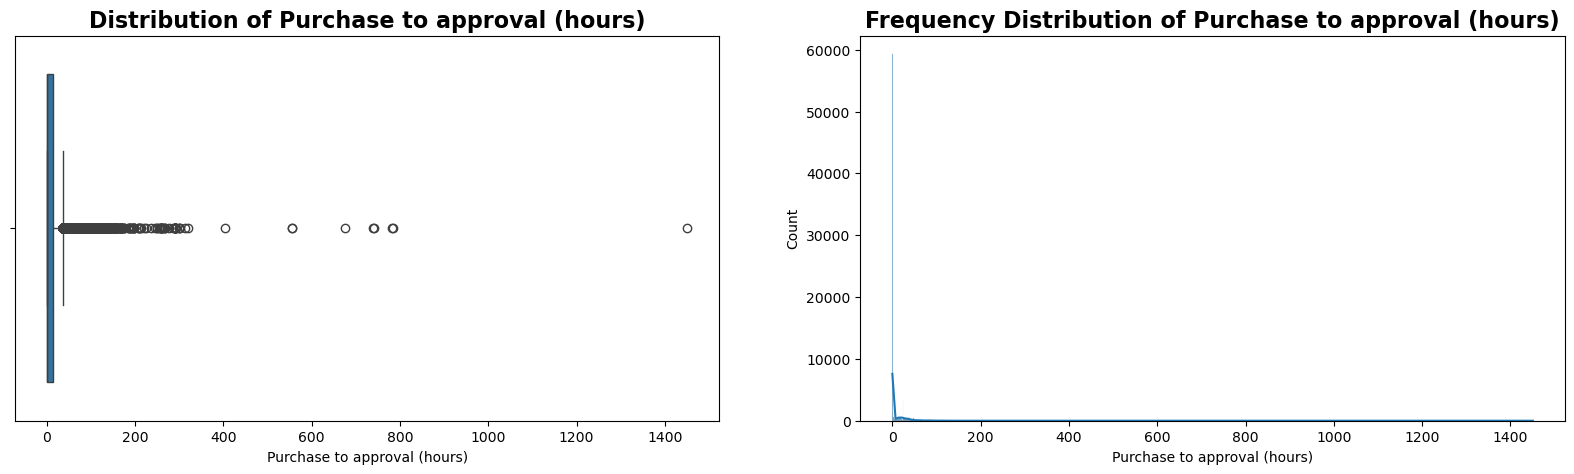

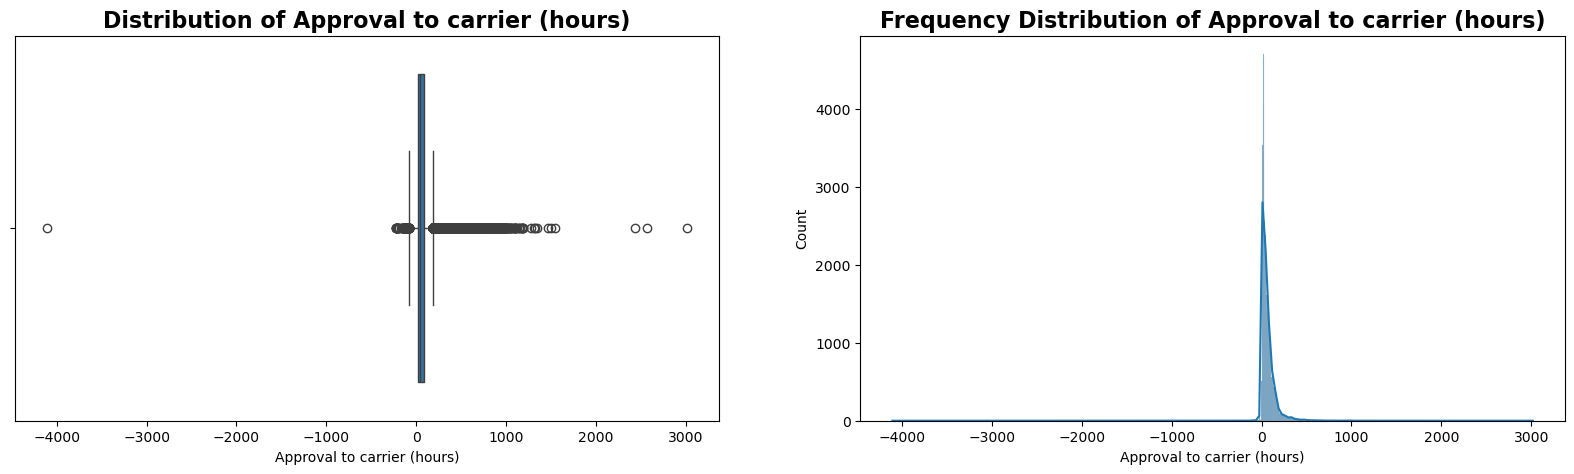

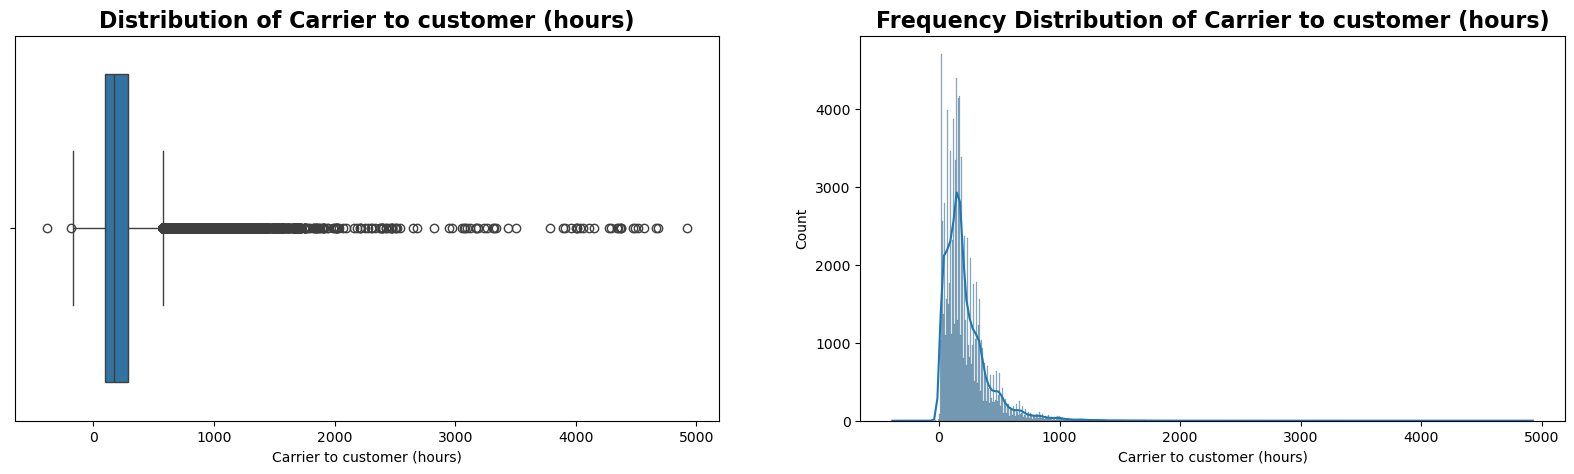

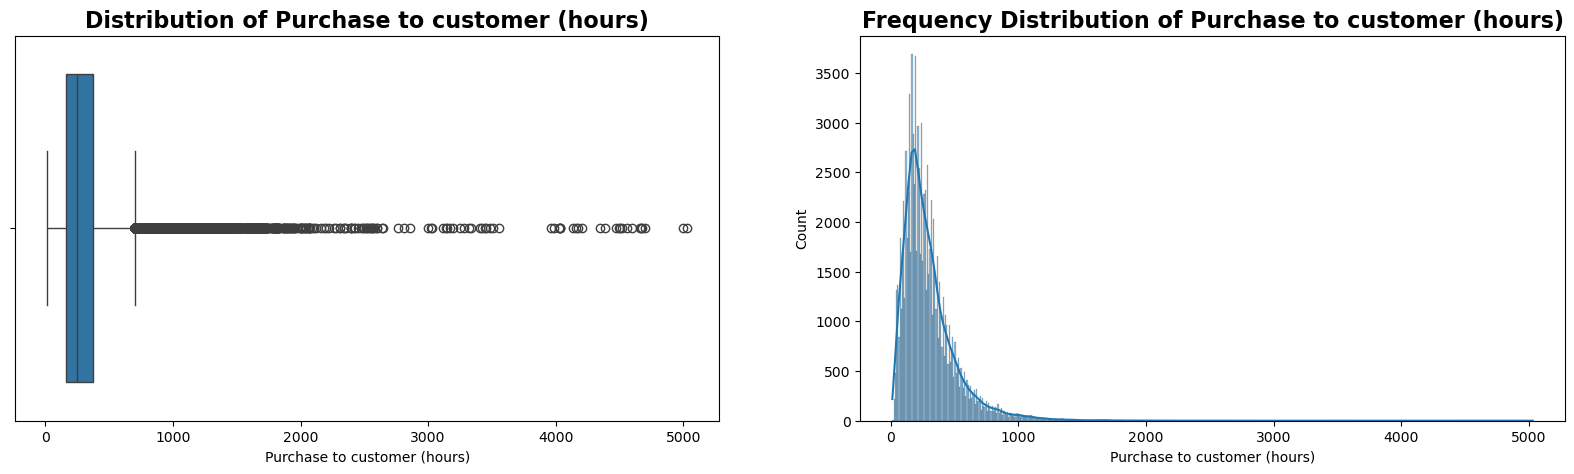

In [25]:
# check for durations data distribution
durations_cols =  ['purchase_to_approval', 'approval_to_carrier', 'carrier_to_customer', 'purchase_to_customer']

for dc in durations_cols:
  showDistributionCombo(orders_df.assign(temp=orders_df[dc] / 3600), 'temp', dc.replace('_', ' ', -1).capitalize() + ' (hours)')

Most orders follow a **tight and consistent delivery timeline**, as indicated by the sharp peaks near zero in all distributions—especially in the `purchase_to_approval` and `approval_to_carrier` durations. However, there are **significant long-tail outliers**, and in the case of `approval_to_carrier`, even **negative values**, which are logically invalid (a carrier date before approval doesn’t make sense). These likely stem from either data entry errors or system timestamp issues and should be carefully handled or removed.

In [26]:
# 1. Negative value removal
orders_df = orders_df[orders_df['approval_to_carrier']>=0]
orders_df = orders_df[orders_df['carrier_to_customer']>=0]

# remove outliers with IQR
for dc in durations_cols:
	Q1 = orders_df[dc].quantile(0.25)
	Q3 = orders_df[dc].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	orders_df = orders_df[(orders_df[dc] >= lower_bound) & (orders_df[dc] <= upper_bound)]

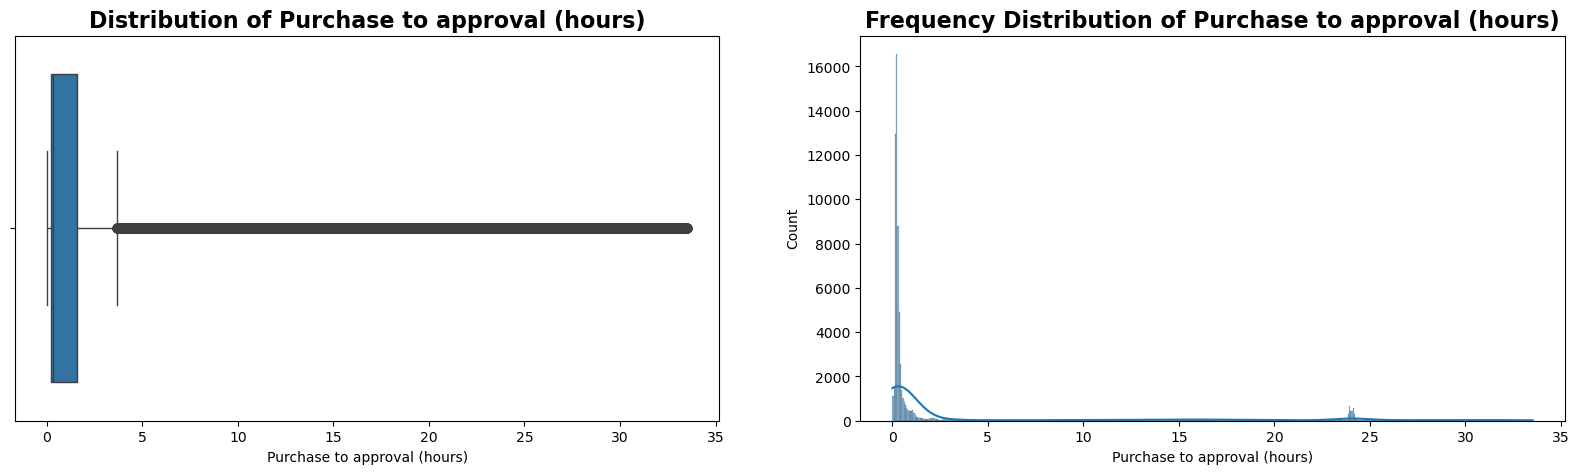

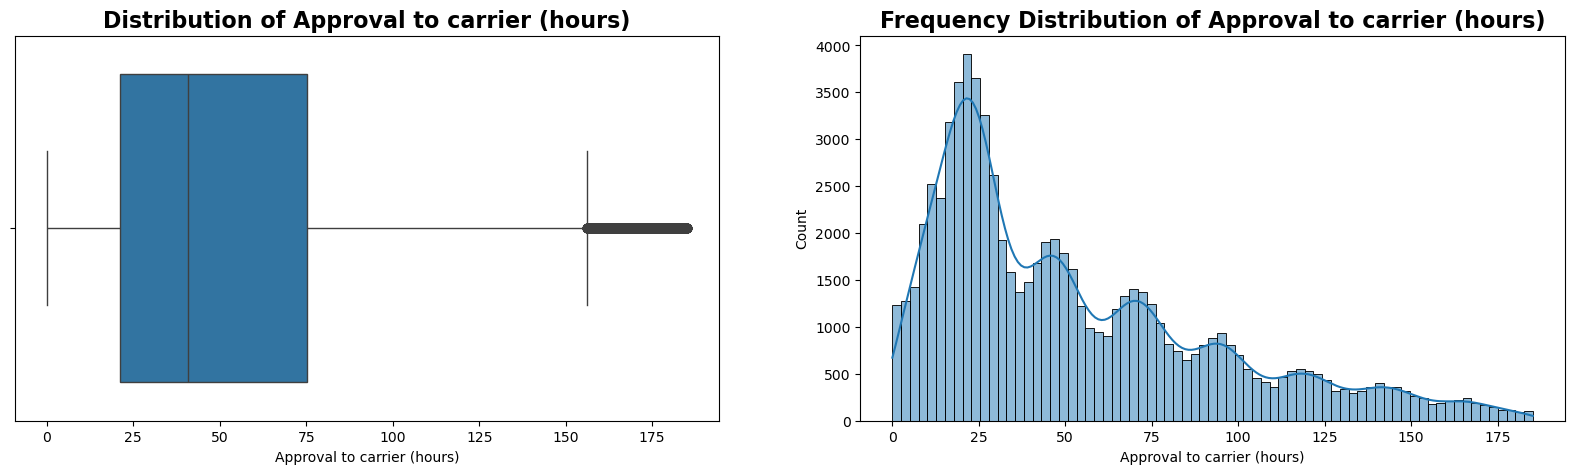

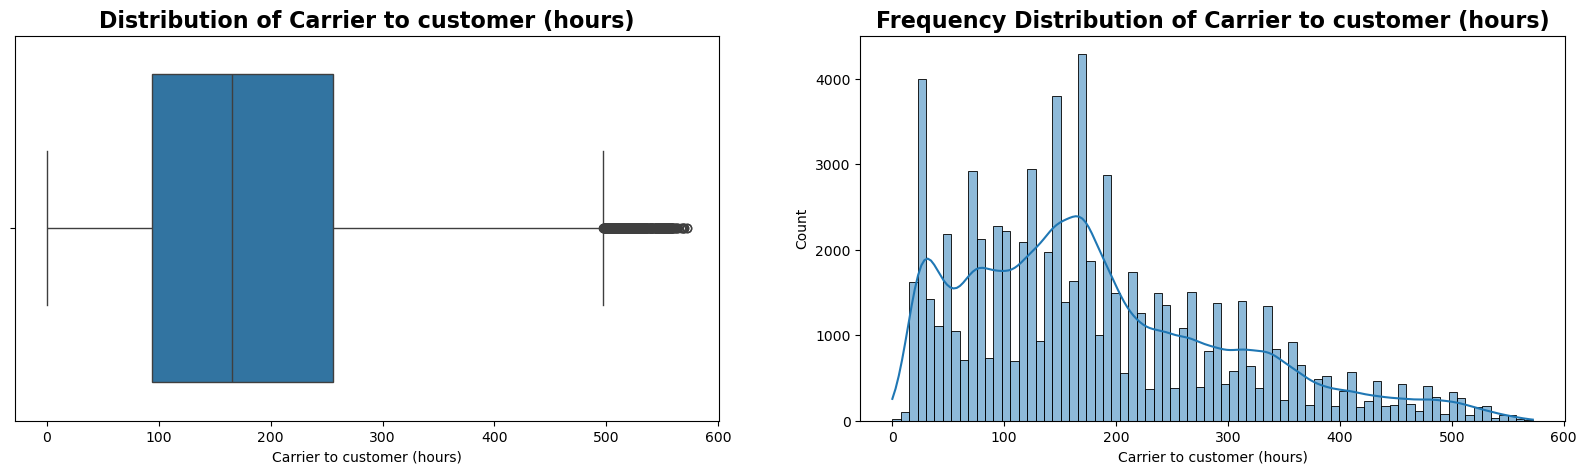

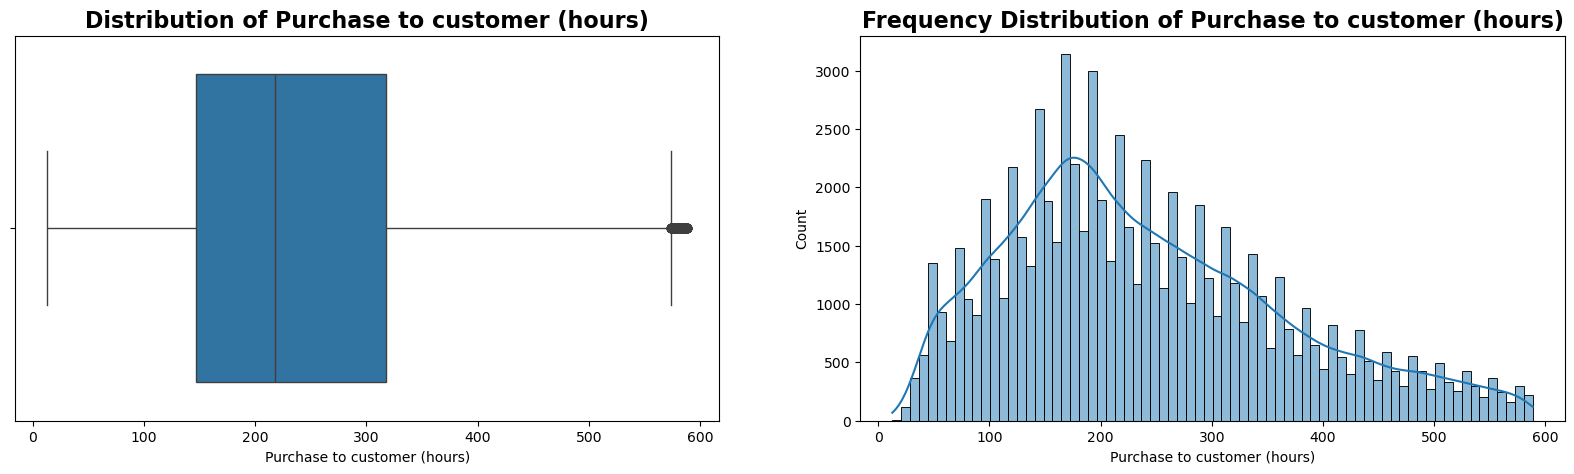

In [27]:
# show final distribution
for dc in durations_cols:
  showDistributionCombo(orders_df.assign(temp=orders_df[dc] / 3600), 'temp', dc.replace('_', ' ', -1).capitalize() + ' (hours)')

#### Save Data

In [28]:
orders_df.to_csv('./dataset/cleaned/olist_orders-cleaned.csv')

### **Order Items Dataset**

**`olist_order_items_dataset.csv` (112,650 rows)**

| Column Name           | Data Type        | Description                                                |
| --------------------- | ---------------- | ---------------------------------------------------------- |
| `order_id`            | `object`/`string`         | Identifier linking to the order.                           |
| `order_item_id`       | `int64`          | Sequential number identifying items within the same order. |
| `product_id`          | `object`/`string`         | Identifier for the purchased product.                      |
| `seller_id`           | `object`/`string`         | Identifier for the seller of the product.                  |
| `shipping_limit_date` | `datetime64` | Latest date the seller should ship the item.               |
| `price`               | `float64`        | Price paid for the item.                                   |
| `freight_value`       | `float64`        | Shipping cost charged for the item.                        |


In [29]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


#### Unique Values

In [30]:
showUniqueValues(order_items_df, 6999)

Column Name  Number of Unique  \
6  freight_value              6999   
5          price              5968   
3      seller_id              3095   
1  order_item_id                21   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Unique Sample  
6                                                                                                                                                                                                                                                                                                                                                                                                                  

#### Handle Column Type

In [31]:
# Change 'shipping_limit_date' into datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

#### Missing Values

In [32]:
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

No missing values, no action needed.

#### Duplicates

In [33]:
order_items_df.duplicated().sum()

0

No duplicates found, no action needed.

#### Feature Engineering

In [34]:
order_items_df['shipping_limit_date_year'] = order_items_df['shipping_limit_date'].dt.year
order_items_df['shipping_limit_date_month'] = order_items_df['shipping_limit_date'].dt.month
order_items_df['shipping_limit_date_day'] = order_items_df['shipping_limit_date'].dt.day
order_items_df['shipping_limit_date_hour'] = order_items_df['shipping_limit_date'].dt.hour
order_items_df['shipping_limit_date_minute'] = order_items_df['shipping_limit_date'].dt.minute
order_items_df['shipping_limit_date_second'] = order_items_df['shipping_limit_date'].dt.second

#### Unrealistic Values/Outliers

In [35]:
print('Before:', len(order_items_df))

# Keep only orders that exist in orders_df
order_items_df = order_items_df[order_items_df['order_id'].isin(orders_df['order_id'])]

print('after', len(order_items_df))

Before: 112650
after 85850


In [36]:
# check date - year values
order_items_df['shipping_limit_date_year'].value_counts()

shipping_limit_date_year
2018    47695
2017    38054
2016       99
2020        2
Name: count, dtype: int64

In [37]:
order_items_df = order_items_df[order_items_df['shipping_limit_date_year'] < 2020]

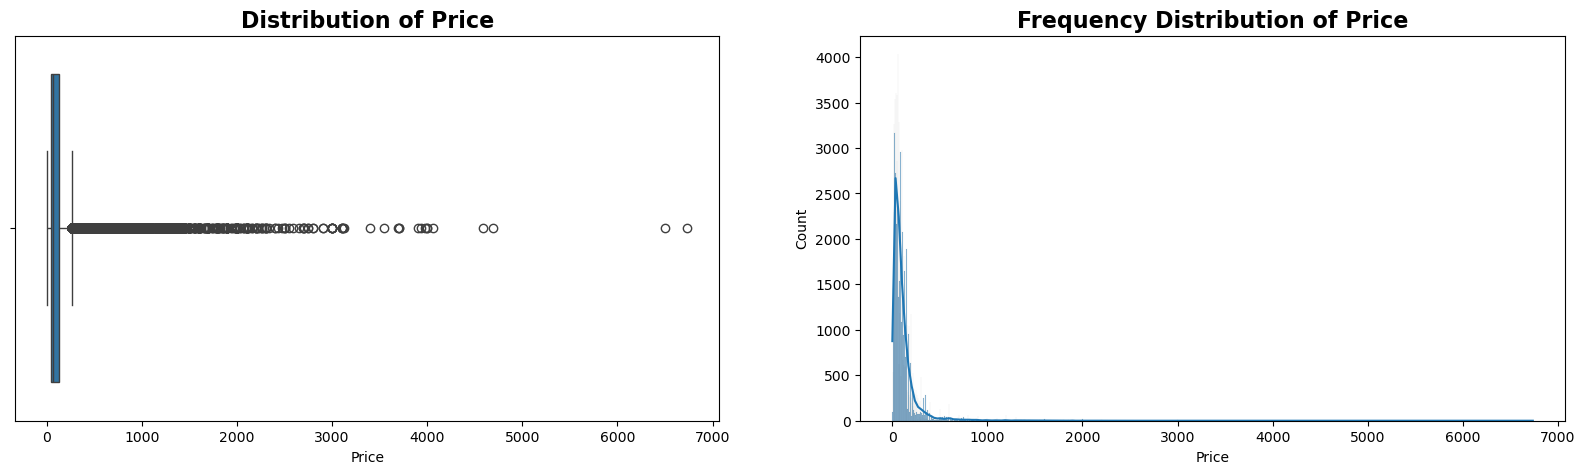

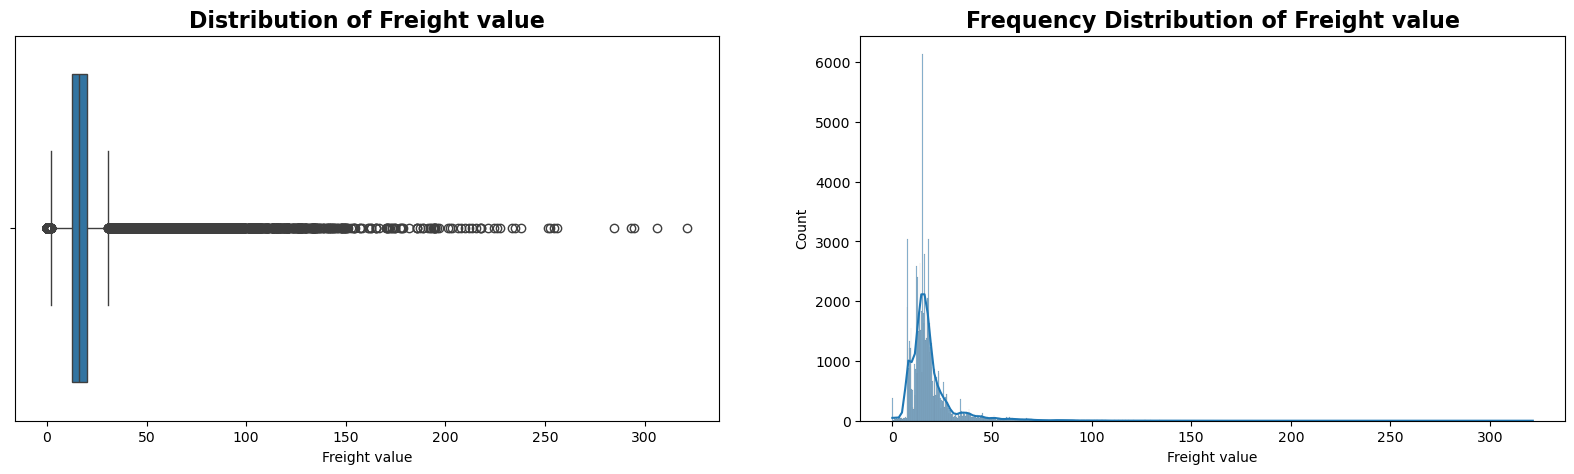

In [38]:
# check price & freight value distribution
order_items_float_cols = ['price', 'freight_value']

for oifc in order_items_float_cols:
  showDistributionCombo(order_items_df, oifc, oifc.replace('_', ' ', -1).capitalize())

The visualizations highlight that both `price` and `freight_value` are highly right-skewed with a dense concentration of values near the lower range and a long tail of high-value outliers. The boxplots clearly show numerous outliers extending beyond the whiskers, while the histograms indicate that most data points lie under ~500 BRL for price and ~50 BRL for freight value. To clean this data, the **Interquartile Range (IQR)** method is recommended for removing outliers.


In [39]:
# remove outliers with IQR
for oifc in order_items_float_cols:
	Q1 = order_items_df[oifc].quantile(0.25)
	Q3 = order_items_df[oifc].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	order_items_df = order_items_df[(order_items_df[oifc] >= lower_bound) & (order_items_df[oifc] <= upper_bound)]

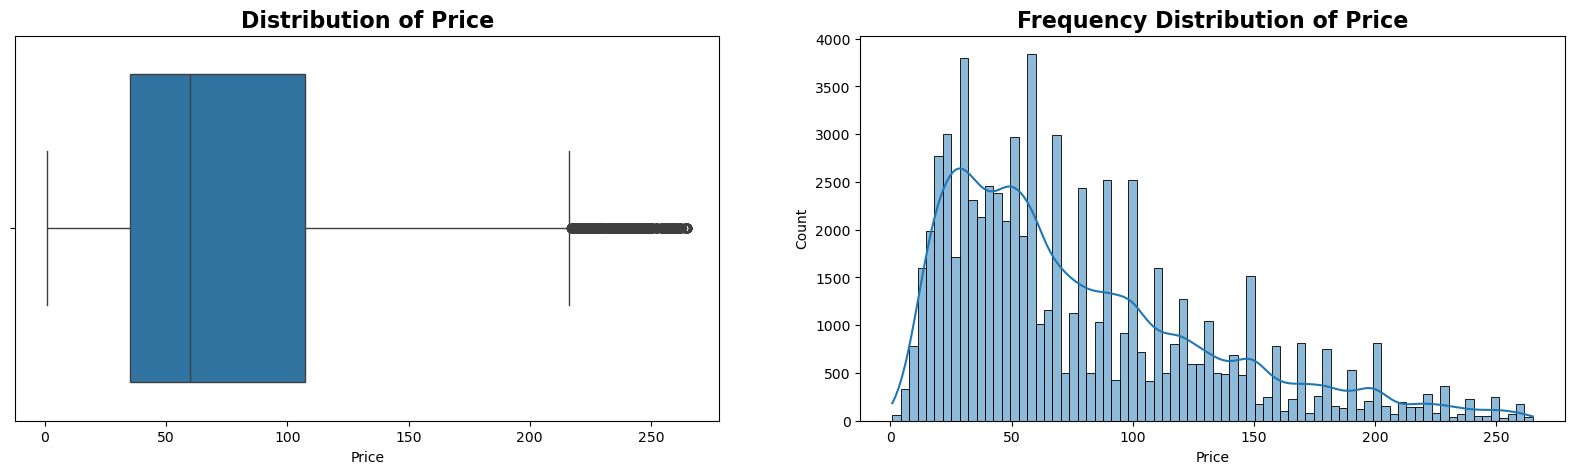

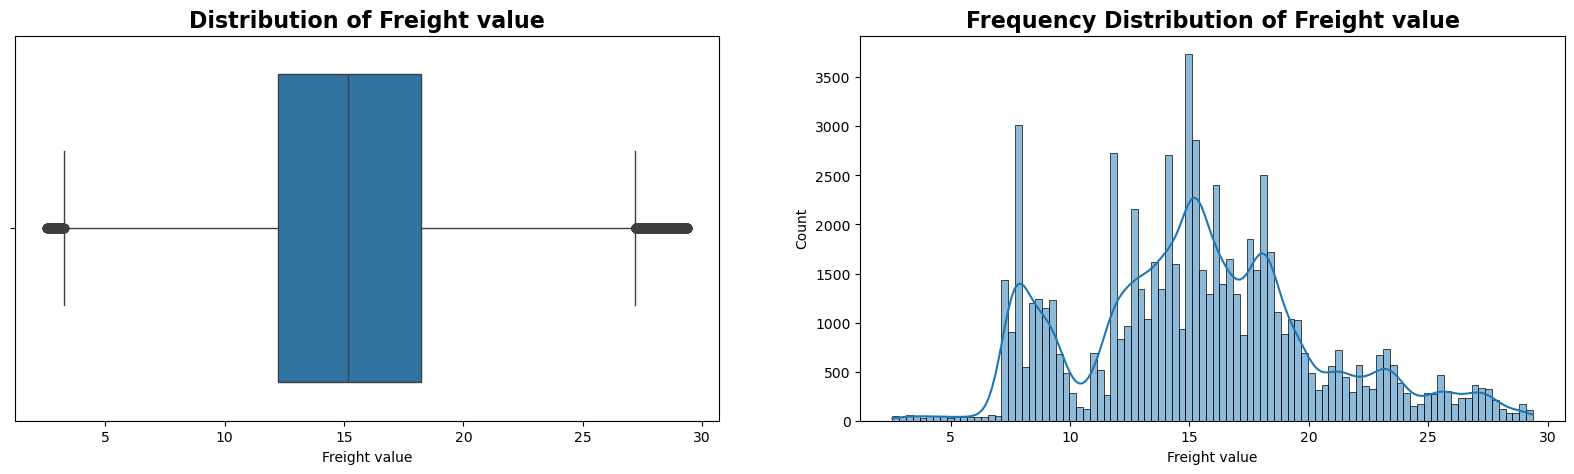

In [40]:
for oifc in order_items_float_cols:
  showDistributionCombo(order_items_df, oifc, oifc.replace('_', ' ', -1).capitalize())

#### Save Data

In [41]:
order_items_df.to_csv('./dataset/cleaned/olist_order_items-cleaned.csv')

### **Order Payments**

**`olist_order_payments_dataset.csv` (103,886 rows)**

| Column Name            | Data Type | Description                                                         |
| ---------------------- | --------- | ------------------------------------------------------------------- |
| `order_id`             | `object`/`string`  | Identifier linking to the order.                                    |
| `payment_sequential`   | `int64`   | Sequential number identifying multiple payments for the same order. |
| `payment_type`         | `object`/`string`  | Payment method used (e.g., credit card, boleto).                    |
| `payment_installments` | `int64`   | Number of installments for the payment.                             |
| `payment_value`        | `float64` | Total amount paid in the transaction.                               |

In [42]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


#### Unique Values

In [43]:
showUniqueValues(order_payments_df, 29077)

Column Name  Number of Unique  \
4         payment_value             29077   
1    payment_sequential                29   
3  payment_installments                24   
2          payment_type                 5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Unique Sample  
4  [0.0, 0.01, 0.03, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.14, 0.15, 0.16, 0.17, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.31, 0.32, 0.33, 0.34, 0.36, 0.37, 0.38, 0.39, 0.41, 0.42, 0.43, 0.44, 0.47, 0.48, 0.49, 0.52, 0.53, 0.54, 0.55, 0.56, 0.58, 0.59, 0.6, 0.61, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.72, 0.73, 0.74, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.91, 0.92, 0.93, 0.94, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.14, 1.15, 1.16, 1.17, 1.18, 1.2, 1.21, 1.22, 1.23, ...]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24]  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [boleto, credit_card, debit_card, not_defined, voucher]

#### Handle Column Type

In [44]:
# Change 'shipping_limit_date' into datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

#### Missing Values

In [45]:
order_payments_df.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

#### Duplicates

In [46]:
order_payments_df.duplicated().sum()

0

#### Unrealistic Values/Outliers

In [47]:
print('Before:', len(order_payments_df))

# Keep only orders that exist in orders_df
order_payments_df = order_payments_df[order_payments_df['order_id'].isin(orders_df['order_id'])]

print('after', len(order_payments_df))

Before: 103886
after 78888


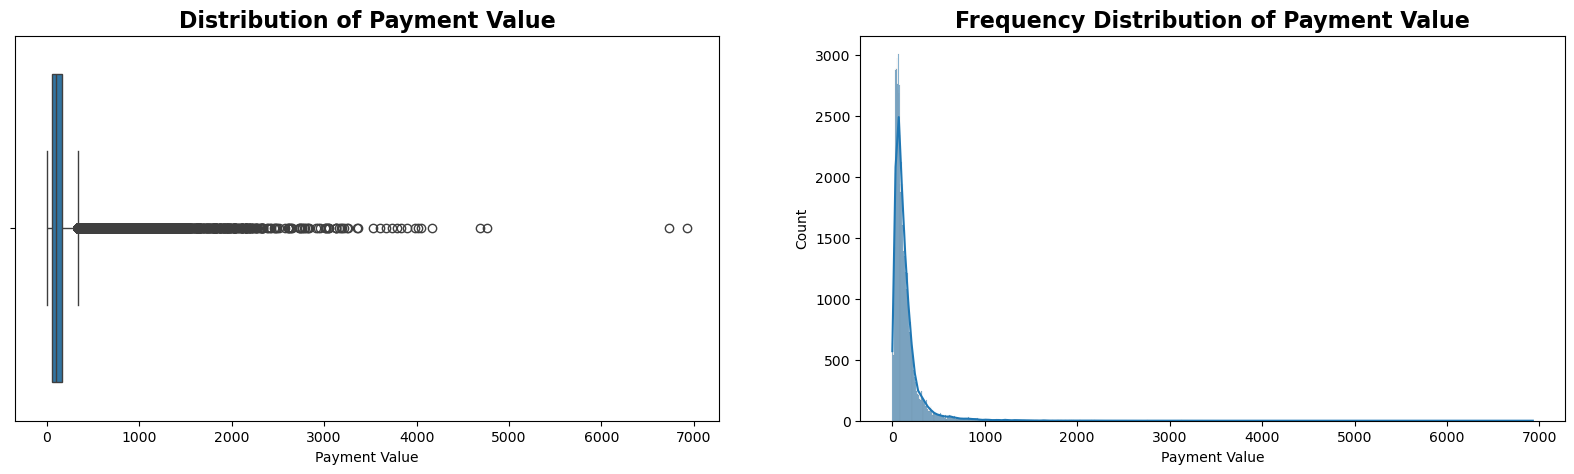

In [48]:
showDistributionCombo(order_payments_df, 'payment_value', 'Payment Value')

The visualization of `payment_value` shows a strong right skew, where most transactions fall below 1,000, while a small number of extreme values reach up to nearly 14,000. The box plot confirms a dense cluster of lower values with many outliers extending far beyond the upper whisker, indicating significant variability among a few high-value orders. Though it might be important, we will remove all data above **6000**.

In [49]:
order_payments_df = order_payments_df[order_payments_df['payment_value'] <= 6000]

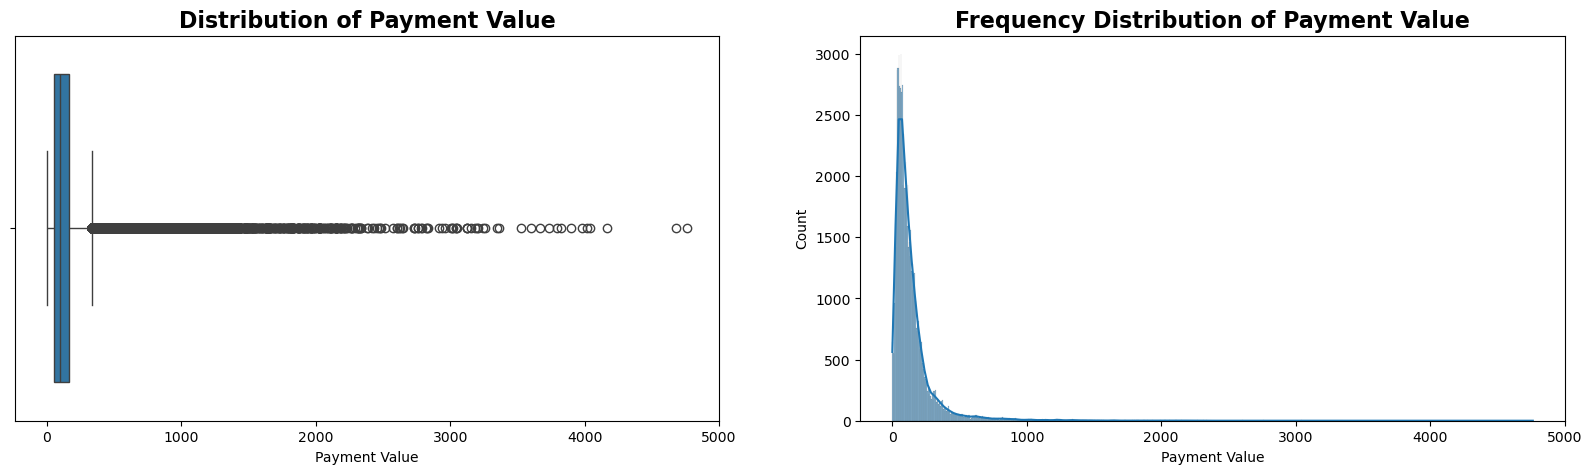

In [50]:
showDistributionCombo(order_payments_df, 'payment_value', 'Payment Value')

In [51]:
# check payment type count
order_payments_df['payment_type'].value_counts()

payment_type
credit_card    62952
boleto         10224
voucher         4467
debit_card      1243
Name: count, dtype: int64

The `payment_type` distribution is dominated by credit card transactions, followed by boleto, voucher, and debit card payments. All categories appear valid and interpretable, except for the `not_defined` type, which lacks meaningful context or frequency to support analysis. Therefore, we will remove entries with `not_defined` as their payment type to maintain data quality and ensure consistency in further analysis.

#### Save Data

In [52]:
order_payments_df.to_csv('./dataset/cleaned/olist_order_payments-cleaned.csv')

### **Order Reviews Dataset**

**`olist_order_reviews_dataset.csv` (100,000 rows)**

| Column Name               | Data Type        | Description                                           |
| ------------------------- | ---------------- | ----------------------------------------------------- |
| `review_id`               | `object`/`string`         | Unique identifier for each review.                    |
| `order_id`                | `object`/`string`         | Identifier linking to the order.                      |
| `review_score`            | `int64`          | Score given by the customer (1 to 5).                 |
| `review_comment_title`    | `object`/`string`         | Title of the review comment.                          |
| `review_comment_message`  | `object`/`string`         | Content of the review comment.                        |
| `review_creation_date`    | `object`/`string` | Date when the review was created.                     |
| `review_answer_timestamp` | `object`/`string` | Timestamp when the review was answered by the seller. |

In [53]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


#### Unique Values

In [54]:
showUniqueValues(order_reviews_df, 36159)

Column Name  Number of Unique  \
4  review_comment_message             36159   
3    review_comment_title              4527   
5    review_creation_date               636   
2            review_score                 5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#### Handle Column Types

In [55]:
# Change 'review_creation_date' & 'review_answer_timestamp' into datetime
order_reviews_df['review_creation_date'] = pd.to_datetime(order_reviews_df['review_creation_date'])
order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])

#### Missing Values

In [56]:
order_reviews_df.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

We can see that there are loads of missing values in the title & message sections, which is expected. To handle this we will be changing these values to an empty string.

In [57]:
order_reviews_df['review_comment_title'] = order_reviews_df['review_comment_title'].fillna('')
order_reviews_df['review_comment_message'] = order_reviews_df['review_comment_message'].fillna('')

#### Duplicates

In [58]:
order_reviews_df.duplicated().sum()

0

#### Feature Engineering

In [59]:
review_dt_cols = ['review_creation_date', 'review_answer_timestamp']

for rdc in review_dt_cols:
	order_reviews_df[f'{rdc}_year'] = order_reviews_df[rdc].dt.year
	order_reviews_df[f'{rdc}_month'] = order_reviews_df[rdc].dt.month
	order_reviews_df[f'{rdc}_day'] = order_reviews_df[rdc].dt.day
	order_reviews_df[f'{rdc}_hour'] = order_reviews_df[rdc].dt.hour
	order_reviews_df[f'{rdc}_minute'] = order_reviews_df[rdc].dt.minute
	order_reviews_df[f'{rdc}_second'] = order_reviews_df[rdc].dt.second

#### Unrealistic Values/Outliers

In [60]:
# check for unique timestamp data
for rdc in review_dt_cols:
  print(order_reviews_df[f'{rdc}_year'].value_counts(), '\n')

review_creation_date_year
2018    56164
2017    42735
2016      325
Name: count, dtype: int64 

review_answer_timestamp_year
2018    56843
2017    42070
2016      311
Name: count, dtype: int64 



In [61]:
for rdc in review_dt_cols:
  print(order_reviews_df[f'{rdc}_hour'].value_counts(), '\n')

review_creation_date_hour
0    99139
1       85
Name: count, dtype: int64 

review_answer_timestamp_hour
23    6982
11    6938
0     6487
12    6411
21    5885
22    5795
1     5718
13    5370
19    5081
20    5071
10    4987
14    4926
18    4357
15    4327
17    4235
16    4212
2     3778
9     2679
3     2320
4     1136
8     1062
5      576
7      467
6      424
Name: count, dtype: int64 



In [62]:
print('Before:', len(order_reviews_df))

# Keep only orders that exist in orders_df
order_reviews_df = order_reviews_df[order_reviews_df['order_id'].isin(orders_df['order_id'])]

print('after', len(order_reviews_df))

Before: 99224
after 75414


#### Save Data

In [63]:
order_reviews_df.to_csv('./dataset/cleaned/olist_review-cleaned.csv')

### **Products Dataset**

**`olist_products_dataset.csv` (32,951 rows)**

| Column Name                  | Data Type | Description                                   |
| ---------------------------- | --------- | --------------------------------------------- |
| `product_id`                 | `object`/`string`  | Unique identifier for each product.           |
| `product_category_name`      | `object`/`string`  | Category of the product (in Portuguese).      |
| `product_name_lenght`        | `float64` | Length of the product name.                   |
| `product_description_lenght` | `float64` | Length of the product description.            |
| `product_photos_qty`         | `float64` | Number of photos associated with the product. |
| `product_weight_g`           | `float64` | Weight of the product in grams.               |
| `product_length_cm`          | `float64` | Length of the product package in centimeters. |
| `product_height_cm`          | `float64` | Height of the product package in centimeters. |
| `product_width_cm`           | `float64` | Width of the product package in centimeters.  |

In [64]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### Unique Values

In [65]:
showUniqueValues(products_df, 2960)

Column Name  Number of Unique  \
3  product_description_lenght              2960   
5            product_weight_g              2204   
7           product_height_cm               102   
6           product_length_cm                99   
8            product_width_cm                95   
1       product_category_name                73   
2         product_name_lenght                66   
4          product_photos_qty                19   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Unique Sample  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [4.0, 8.0, 15.0, 20.0, 23.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, ...]  
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### Missing Values

In [66]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Most of the values missing are floats, so we can change that to 0 or an empty string

In [67]:
products_df['product_name_lenght'] = products_df['product_name_lenght'].fillna(0)
products_df['product_description_lenght'] = products_df['product_description_lenght'].fillna(0)
products_df['product_photos_qty'] = products_df['product_photos_qty'].fillna(0)
products_df['product_category_name'] = products_df['product_category_name'].fillna('')

#### Handle Column Types

In [68]:
products_df['product_name_lenght'] = products_df['product_name_lenght'].astype(int)
products_df['product_description_lenght'] = products_df['product_description_lenght'].astype(int)
products_df['product_photos_qty'] = products_df['product_photos_qty'].astype(int)

Change floats into int.

#### Duplicates

In [69]:
products_df.duplicated().sum()

0

#### Feature Engineering

In [70]:
products_df['product_volume_cm3'] =  products_df['product_length_cm'] * products_df['product_height_cm'] * products_df['product_width_cm']

Add product volume calculation

#### Unrealistic Values/Outliers

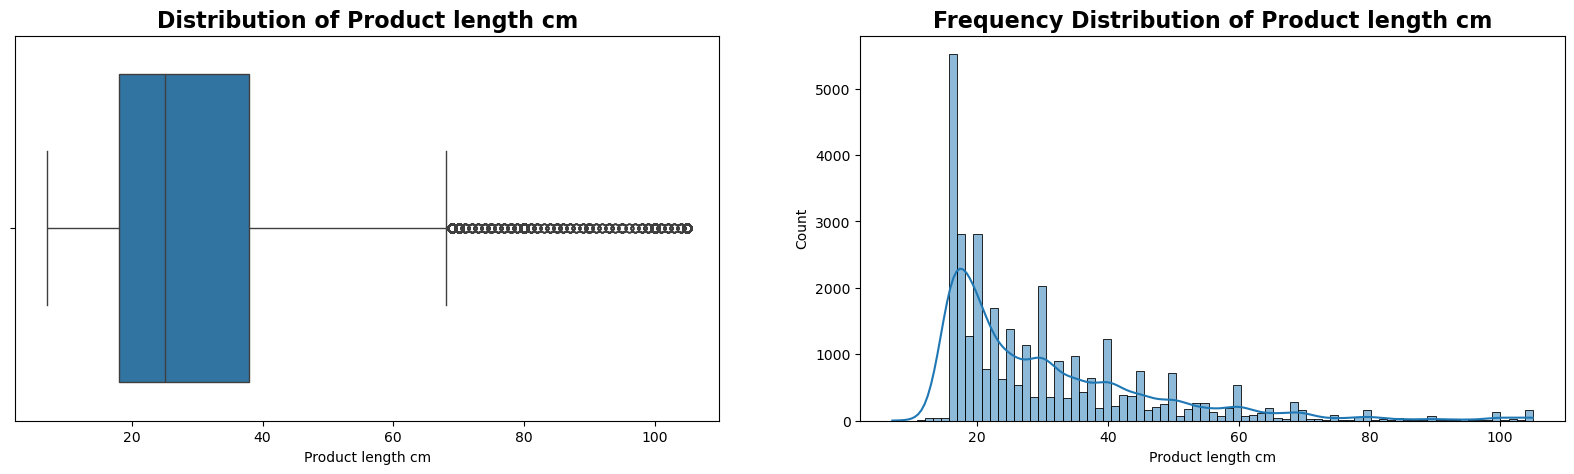

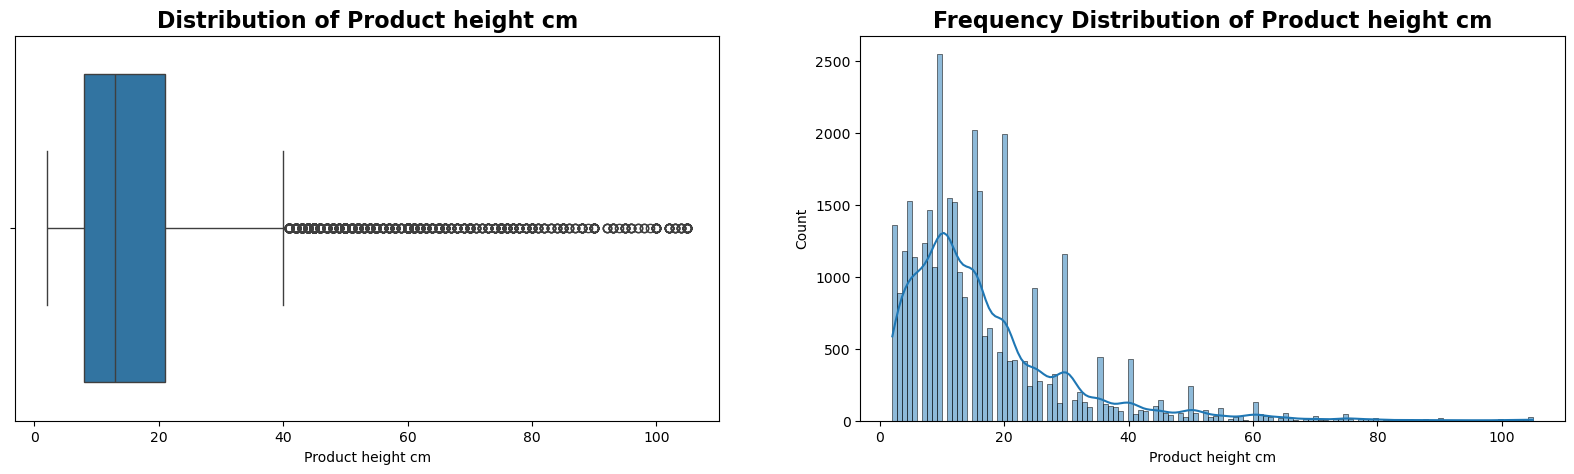

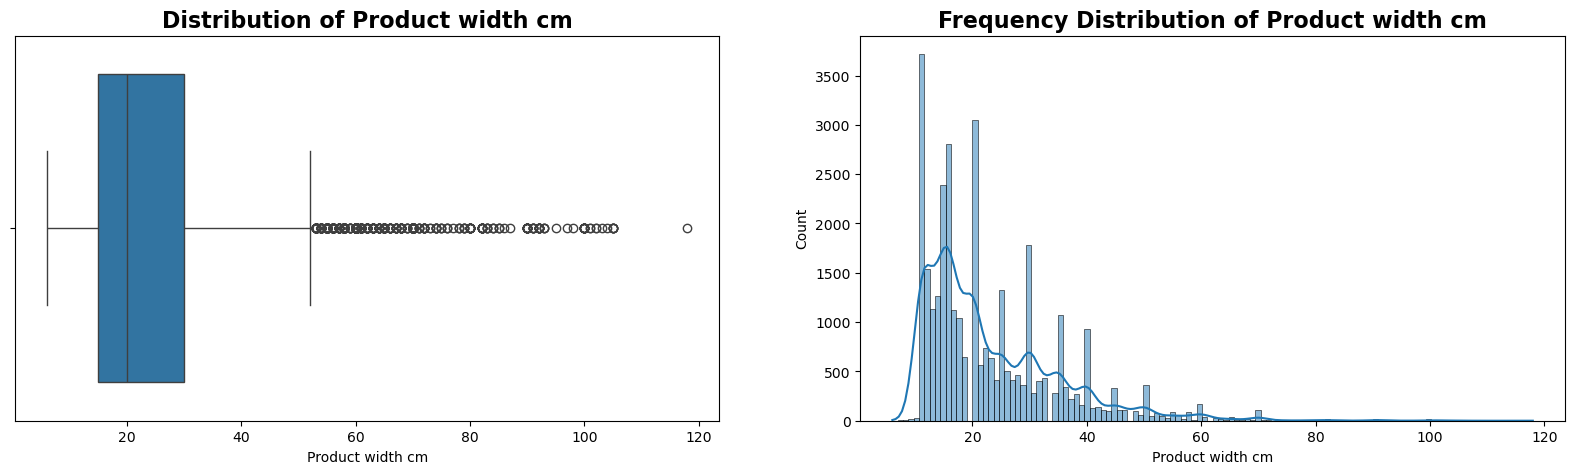

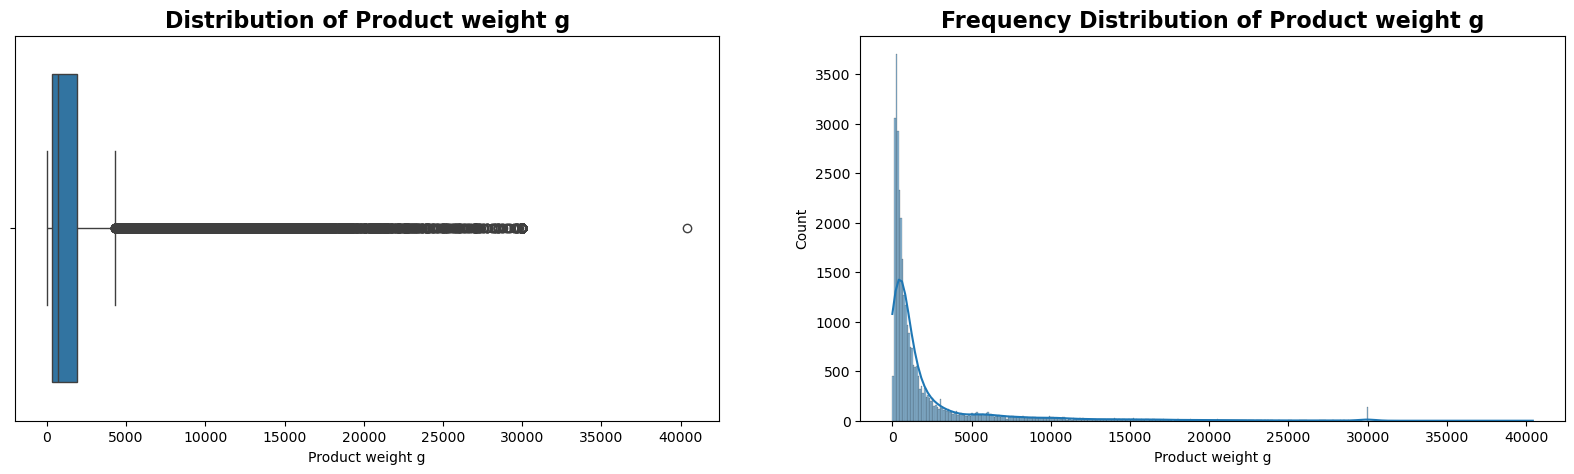

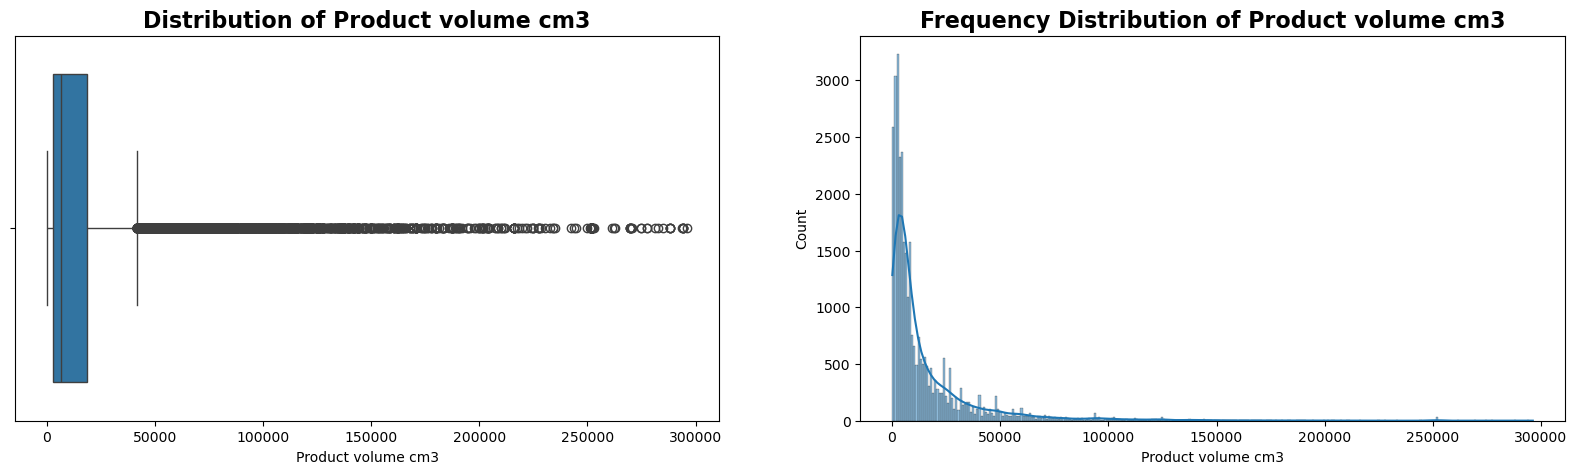

In [71]:
# check price & freight value distribution
products_float_cols = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g', 'product_volume_cm3']

for oifc in products_float_cols:
  showDistributionCombo(products_df, oifc, oifc.replace('_', ' ', -1).capitalize())

Based on the charts we can see there are 2 distinct outliers on `product_weight_g` and `product_width_cm`. We can also see that the distribution of `volume` and `weight` is rather similar, which aligns logically. Let's take a look if the 2 outliers are the same row.

In [72]:
products_df[(products_df['product_weight_g']>35000) | (products_df['product_width_cm']>112)]

product_id product_category_name  \
25166  26644690fde745fc4654719c3904e1db       cama_mesa_banho   
26970  b17808303e15dd50538c011b44295427       cama_mesa_banho   

       product_name_lenght  product_description_lenght  product_photos_qty  \
25166                   59                         534                   1   
26970                   56                         502                   3   

       product_weight_g  product_length_cm  product_height_cm  \
25166           40425.0               13.0               65.0   
26970            1050.0               23.0               93.0   

       product_width_cm  product_volume_cm3  
25166              28.0             23660.0  
26970             118.0            252402.0

It appears that those are 2 different items. The products' data also does not look logical / realistic, according to their weights and volume. We will remove them.

In [73]:
products_df['product_weight_g'] = products_df['product_weight_g']<35000
products_df['product_width_cm'] = products_df['product_width_cm']<112

#### Translate Categories

In [74]:
# translate product categories
products_df = products_df.merge(pcateg_translation_df, on='product_category_name', how='inner')
products_df = products_df.drop(columns=['product_category_name'])
products_df = products_df.rename(columns={'product_category_name_english': 'product_category_name'})

In [75]:
products_df

product_id  product_name_lenght  \
0      1e9e8ef04dbcff4541ed26657ea517e5                   40   
1      3aa071139cb16b67ca9e5dea641aaa2f                   44   
2      96bd76ec8810374ed1b65e291975717f                   46   
3      cef67bcfe19066a932b7673e239eb23d                   27   
4      9dc1a7de274444849c219cff195d0b71                   37   
...                                 ...                  ...   
32323  a0b7d5a992ccda646f2d34e418fff5a0                   45   
32324  bf4538d88321d0fd4412a93c974510e6                   41   
32325  9a7c6041fa9592d9d9ef6cfe62a71f8c                   50   
32326  83808703fc0706a22e264b9d75f04a2e                   60   
32327  106392145fca363410d287a815be6de4                   58   

       product_description_lenght  product_photos_qty  product_weight_g  \
0                             287                   1              True   
1                             276                   1              True   
2                             250                   1              True   
3                             261                   1              True   
4                             402                   4              True   
...                           ...                 ...               ...   
32323                          67                   2              True   
32324                         971                   1              True   
32325                         799                   1              True   
32326                         156                   2              True   
32327                         309                   1              True   

       product_length_cm  product_height_cm  product_width_cm  \
0                   16.0               10.0              True   
1                   30.0               18.0              True   
2                   18.0                9.0              True   
3                   26.0                4.0              True   
4                   20.0               17.0              True   
...                  ...                ...               ...   
32323               40.0               40.0              True   
32324               16.0               19.0              True   
32325               27.0                7.0              True   
32326               31.0               13.0              True   
32327               12.0                2.0              True   

       product_volume_cm3      product_category_name  
0                  2240.0                  perfumery  
1                 10800.0                        art  
2                  2430.0             sports_leisure  
3                  2704.0                       baby  
4                  4420.0                 housewares  
...                   ...                        ...  
32323             64000.0            furniture_decor  
32324              4864.0  construction_tools_lights  
32325              5103.0             bed_bath_table  
32326              8060.0      computers_accessories  
32327               168.0             bed_bath_table  

[32328 rows x 10 columns]

#### Map Categories Into Smaller Groups

In [76]:
category_master_map = {
  'agro_industry_and_commerce': 'Agriculture',
  'food': 'Food',
  'food_drink': 'Food',
  'art': 'Stationery & Art',
  'arts_and_craftmanship': 'Stationery & Art',
  'party_supplies': 'Party',
  'christmas_supplies': 'Party',
  'audio': 'Electronics',
  'auto': 'Auto',
  'baby': 'Toys & Baby',
  'drinks': 'Food',
  'health_beauty': 'Health & Beauty',
  'toys': 'Toys & Baby',
  'bed_bath_table': 'Home & Living',
  'home_confort': 'Home & Living',
  'home_comfort_2': 'Home & Living',
  'home_construction': 'Construction',
  'cds_dvds_musicals': 'Entertainment',
  'cine_photo': 'Electronics',
  'air_conditioning': 'Appliances',
  'consoles_games': 'Toys & Baby',
  'construction_tools_construction': 'Construction',
  'costruction_tools_tools': 'Construction',
  'construction_tools_lights': 'Construction',
  'costruction_tools_garden': 'Construction',
  'construction_tools_safety': 'Construction',
  'cool_stuff': 'Miscellaneous',
  'dvds_blu_ray': 'Entertainment',
  'home_appliances': 'Appliances',
  'home_appliances_2': 'Appliances',
  'electronics': 'Electronics',
  'small_appliances': 'Appliances',
  'sports_leisure': 'Sports & Outdoors',
  'fashion_bags_accessories': 'Fashion',
  'fashion_shoes': 'Fashion',
  'fashion_sport': 'Fashion',
  'fashio_female_clothing': 'Fashion',
  'fashion_childrens_clothes': 'Fashion',
  'fashion_male_clothing': 'Fashion',
  'fashion_underwear_beach': 'Fashion',
  'garden_tools': 'Construction',
  'flowers': 'Flowers',
  'diapers_and_hygiene': 'Health & Baby',
  'industry_commerce_and_business': 'Business',
  'computers_accessories': 'Electronics',
  'musical_instruments': 'Entertainment',
  'la_cuisine': 'Kitchen',
  'books_imported': 'Books',
  'books_general_interest': 'Books',
  'books_technical': 'Books',
  'luggage_accessories': 'Travel',
  'market_place': 'Miscellaneous',
  'furniture_mattress_and_upholstery': 'Furniture',
  'kitchen_dining_laundry_garden_furniture': 'Furniture',
  'furniture_decor': 'Furniture',
  'office_furniture': 'Furniture',
  'furniture_bedroom': 'Furniture',
  'furniture_living_room': 'Furniture',
  'music': 'Entertainment',
  'stationery': 'Stationery & Art',
  'computers': 'Electronics',
  'perfumery': 'Health & Beauty',
  'pet_shop': 'Pets',
  'small_appliances_home_oven_and_coffee': 'Appliances',
  'watches_gifts': 'Gifts',
  'security_and_services': 'Services',
  'signaling_and_security': 'Construction',
  'tablets_printing_image': 'Electronics',
  'telephony': 'Electronics',
  'fixed_telephony': 'Electronics',
  'housewares': 'Home & Living'
}

# Map to new column
products_df['product_master_category_name'] = products_df['product_category_name'].map(category_master_map).fillna('Other')

#### Save Data

In [77]:
products_df.to_csv('./dataset/cleaned/olist_products-cleaned.csv')

### **Sellers Dataset**


**`olist_sellers_dataset.csv` (3,095 rows)**

| Column Name              | Data Type | Description                                 |
| ------------------------ | --------- | ------------------------------------------- |
| `seller_id`              | `object`/`string`  | Unique identifier for each seller.          |
| `seller_zip_code_prefix` | `int64`   | First five digits of the seller's zip code. |
| `seller_city`            | `object`/`string`  | City where the seller is located.           |
| `seller_state`           | `object`/`string`  | State where the seller is located.          |

In [78]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


#### Unique Values

In [79]:
showUniqueValues(sellers_df, 2246)

Column Name  Number of Unique  \
1  seller_zip_code_prefix              2246   
2             seller_city               611   
3            seller_state                23   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Unique Sample  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [1001, 1021, 1022, 1023, 1026, 1031, 1035, 1039, 1040, 1041, 1042, 1044, 1123, 1125, 1126, 1127, 1129, 1131, 1139, 1140, 1156, 1201, 1206, 1207, 1208, 1209, 1210, 1212, 1214, 1215, 1220, 1222, 1223, 1224, 1226, 1230, 1233, 1238, 1239, 1244, 1254, 1257, 1303, 1309, 1310, 1311, 1314, 1319, 1320, 1403, 1408, 1411, 1417, 1420, 1421, 1425, 1452, 1511, 1512, 1529, 1530, 1539, 1541, 1545, 1547, 1550, 1552, 2013, 2016, 2022, 2028, 2030, 2034, 2035, 2036, 2040, 2047, 2050, 2051, 2066, 2110, 2112, 2113, 2116, 2117, 2118, 2119, 2122, 2124, 2134, 2150, 2189, 2215, 2220, 2236, 2238, 2242, 2252, 2258, 2261, ...]  
2  [04482255, abadia de goias, afonso claudio, aguas claras df, alambari, alfenas, almirante tamandare, alvares machado, alvorada, americana, amparo, ampere, anapolis, andira-pr, andradas, angra dos reis, angra dos reis rj, ao bernardo do campo, aparecida, aparecida de goiania, aperibe, apucarana, aracaju, aracatuba, araguari, arapongas, araquari, ararangua, araraquara, araras, araucaria, araxa, arinos, armacao dos buzios, arraial d'ajuda (porto seguro), artur nogueira, aruja, arvorezinha, assis, atibaia, auriflama, auriflama/sp, avare, bady bassitt, baependi, bage, bahia, balenario camboriu, balneario camboriu, bandeirantes, barbacena, barbacena/ minas gerais, bariri, barra mansa, barra velha, barretos, barrinha, barro alto, barueri, batatais, bauru, bebedouro, belford roxo, belo horizont, belo horizonte, bento goncalves, bertioga, betim, birigui, blumenau, bocaiuva do sul, bofete, boituva, bom jardim, bom jesus dos perdoes, bombinhas, bonfinopolis de minas, borda da mata, botucatu, braco do norte, braganca paulista, brasilia, brasilia df, brejao, brotas, brusque, buritama, cacador, cachoeira do sul, cachoeirinha, cachoeiro de itapemirim, cafelandia, caieiras, cajamar, california, camanducaia, cambe, camboriu, campanha, campina das missoes, ...]  
3                 

#### Missing Values

In [80]:
sellers_df.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

#### Duplicates

In [81]:
sellers_df.duplicated().sum()

0

#### Save Data

In [82]:
sellers_df.to_csv('./dataset/cleaned/olist_sellers-cleaned.csv')

### **Others**

**`olist_geolocation_dataset.csv` (1,000,016 rows)**

| Column Name                   | Data Type | Description                          |
| ----------------------------- | --------- | ------------------------------------ |
| `geolocation_zip_code_prefix` | `int64`   | First five digits of the zip code.   |
| `geolocation_lat`             | `float64` | Latitude coordinate.                 |
| `geolocation_lng`             | `float64` | Longitude coordinate.                |
| `geolocation_city`            | `object`/`string`  | City corresponding to the zip code.  |
| `geolocation_state`           | `object`/`string`  | State corresponding to the zip code. |

<br>

**`product_category_name_translation.csv` (71 rows)**

| Column Name                     | Data Type | Description                          |
| ------------------------------- | --------- | ------------------------------------ |
| `product_category_name`         | `object`/`string`  | Product category name in Portuguese. |
| `product_category_name_english` | `object`/`string`  | Product category name in English.    |

### **Merge Tables**

In [83]:
# order related data
merged_df = orders_df.merge(order_items_df, on='order_id', how='inner')
merged_df = merged_df.merge(order_payments_df, on='order_id', how='inner')
merged_df = merged_df.merge(order_reviews_df, on='order_id', how='inner')
merged_df = merged_df.merge(products_df, on='product_id', how='inner')

In [84]:
merged_df

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                 ...                               ...   
74532  b0f4af5c1b06e24fef510703bfe9f0a6  8e1ec396e317ff4c82a03ce16a0c3eb3   
74533  880675dff2150932f1601e1c07eadeeb  47cd45a6ac7b9fb16537df2ccffeb5ac   
74534  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
74535  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
74536  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
...            ...                      ...                 ...   
74532    delivered      2017-10-27 15:21:00 2017-10-27 15:32:49   
74533    delivered      2017-02-23 09:05:12 2017-02-23 09:15:11   
74534    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
74535    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
74536    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2017-10-04 19:55:00           2017-10-10 21:25:13   
2              2017-10-04 19:55:00           2017-10-10 21:25:13   
3              2018-07-26 14:31:00           2018-08-07 15:27:45   
4              2018-08-08 13:50:00           2018-08-17 18:06:29   
...                            ...                           ...   
74532          2017-10-30 15:44:34           2017-11-10 17:57:22   
74533          2017-03-01 10:22:52           2017-03-06 11:08:08   
74534          2017-03-10 11:18:03           2017-03-17 15:08:01   
74535          2018-02-07 23:22:42           2018-02-28 17:37:56   
74536          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  order_purchase_timestamp_year  \
0                        2017-10-18                           2017   
1                        2017-10-18                           2017   
2                        2017-10-18                           2017   
3                        2018-08-13                           2018   
4                        2018-09-04                           2018   
...                             ...                            ...   
74532                    2017-11-22                           2017   
74533                    2017-03-22                           2017   
74534                    2017-03-28                           2017   
74535                    2018-03-02                           2018   
74536                    2018-04-03                           2018   

       order_purchase_timestamp_month  order_purchase_timestamp_day  \
0                                  10                             2   
1                                  10                             2   
2                                  10                             2   
3                                   7                            24   
4                                   8                             8   
...                               ...                           ...   
74532                              10                            27   
74533                               2                            23   
7453

In [85]:
# check dupes
print('Duplicates: ', merged_df.duplicated().sum())

# check missing value
print('isna: ', merged_df.isna().sum().sum())

Duplicates:  0
isna:  0


In [86]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74537 entries, 0 to 74536
Data columns (total 86 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   order_id                              74537 non-null  object        
 1   customer_id                           74537 non-null  object        
 2   order_status                          74537 non-null  object        
 3   order_purchase_timestamp              74537 non-null  datetime64[ns]
 4   order_approved_at                     74537 non-null  datetime64[ns]
 5   order_delivered_carrier_date          74537 non-null  datetime64[ns]
 6   order_delivered_customer_date         74537 non-null  datetime64[ns]
 7   order_estimated_delivery_date         74537 non-null  datetime64[ns]
 8   order_purchase_timestamp_year         74537 non-null  int32         
 9   order_purchase_timestamp_month        74537 non-null  int32         
 10

In [87]:
merged_df.to_csv('./dataset/cleaned/olist_MERGED_clean.csv')

## **> Data Analysis**
<hr>

### **Defining Churn**

In [88]:
seller_orders = pd.merge(order_items_df, orders_df, on='order_id', how='inner')

# Seller activity calculation
seller_activity = seller_orders.groupby('seller_id')['order_purchase_timestamp'].agg(['min', 'max', 'count']).reset_index()
seller_activity.columns = ['seller_id', 'first_order_date', 'last_order_date', 'total_orders']
latest_order_date = seller_orders['order_purchase_timestamp'].max()
seller_activity['days_since_last_order'] = (latest_order_date - seller_activity['last_order_date']).dt.days
seller_activity['active_days'] = (seller_activity['last_order_date'] - seller_activity['first_order_date']).dt.days

# Filter for clarity
filtered_df = seller_activity[seller_activity['days_since_last_order'] <= 365]

# Calculate summary stats
median_days = filtered_df['days_since_last_order'].median()
mean_days = filtered_df['days_since_last_order'].mean()
q3_days = filtered_df['days_since_last_order'].quantile(0.75)

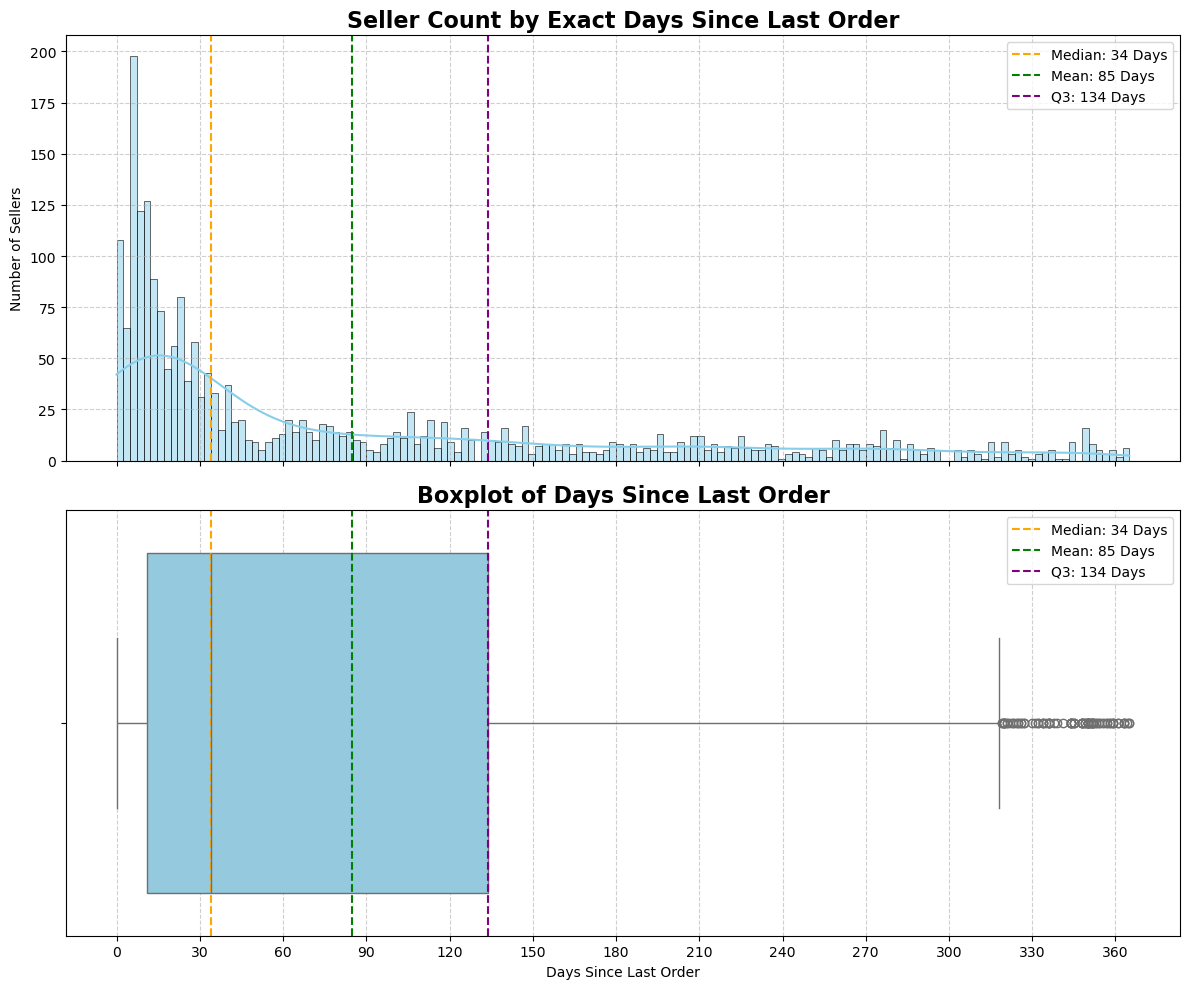

In [89]:
# Plot histogram and boxplot
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Histogram
sns.histplot(
  data=filtered_df,
  x='days_since_last_order',
  bins=150,
  kde=True,
  ax=axes[0],
  color='skyblue'
)
axes[0].axvline(median_days, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_days:.0f} Days')
axes[0].axvline(mean_days, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_days:.0f} Days')
axes[0].axvline(q3_days, color='purple', linestyle='--', linewidth=1.5, label=f'Q3: {q3_days:.0f} Days')
axes[0].set_title('Seller Count by Exact Days Since Last Order', fontdict={'fontsize': 16,'fontweight' : 'bold'})
axes[0].set_ylabel('Number of Sellers')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Boxplot
sns.boxplot(
  data=filtered_df,
  x='days_since_last_order',
  ax=axes[1],
  color='skyblue'
)
axes[1].axvline(median_days, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_days:.0f} Days')
axes[1].axvline(mean_days, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_days:.0f} Days')
axes[1].axvline(q3_days, color='purple', linestyle='--', linewidth=1.5, label=f'Q3: {q3_days:.0f} Days')
axes[1].set_title('Boxplot of Days Since Last Order', fontdict={'fontsize': 16,'fontweight' : 'bold'})
axes[1].set_xlabel('Days Since Last Order')
axes[1].legend()
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.xticks(np.arange(0, filtered_df['days_since_last_order'].max() + 1, 30))
plt.tight_layout()
plt.show()


This plot reveals a clear decay pattern in seller engagement. A **significant concentration of sellers become inactive within the first 30 days** since their last order — peaking sharply at day 1 and gradually tapering off. This indicates many sellers go dormant almost immediately after their last recorded sale, possibly due to short-lived activity, failed product-market fit, or low platform adoption.

Given this pattern, the **median inactivity time of 34 days** offers a statistically grounded and balanced threshold. It reflects the point at which half of all sellers have already become inactive, making it a logical cutoff for identifying churn. This avoids overly reactive classifications while still capturing early signs of disengagement.

With this in mind, we will now label sellers as either:

|Label|Description|
|-----|-----------|
|`1 = Churned` | No orders in the last **34 days** |
|`0 = Active` | Has at least one order within the last **34 days** |

This label becomes our **target variable** for modeling or exploratory analysis going forward.


In [90]:
# Define churn label: 1 if inactive for more than 34 days, else 0
churn_threshold = 34
seller_activity['churned'] = (seller_activity['days_since_last_order'] > churn_threshold).astype(int)

churn_counts = seller_activity['churned'].value_counts().sort_index()
churn_labels = ['Active [0]', 'Churned [1]']
churn_percent = (churn_counts / churn_counts.sum() * 100).round(1)

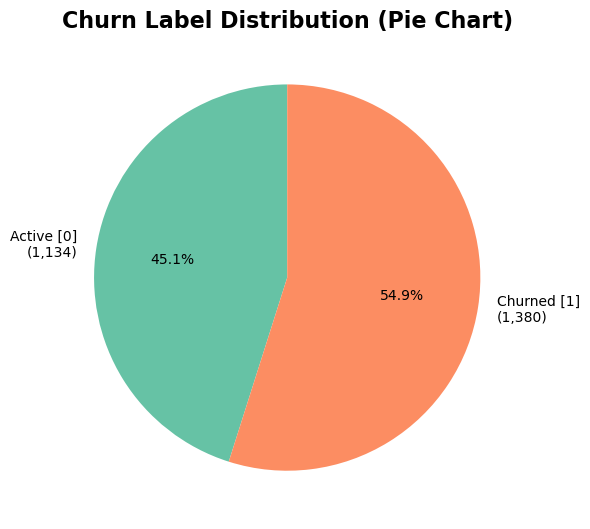

In [91]:
# Pie chart settings
colors = ['#66c2a5', '#fc8d62']  # Match Set2

pltFigsize((6, 6))
pltTitle('Churn Label Distribution (Pie Chart)')

plt.pie(
  churn_counts,
  labels=[f'{label}\n({count:,})' for label, count in zip(churn_labels, churn_counts)],
  autopct='%1.1f%%',
  startangle=90,
  colors=colors,
)

plt.tight_layout()
plt.show()

Turns out that we have **1,134 (45.1%)** sellers who aren't churning and **1,380 (54.9%)** who are churning. This indicates no concerns in terms of class imbalance for modelling.

Now let's figure out the reasoning behing these churners. Are their sales just not performing? or perhaps are they just not interested in the platform (short active time)? Let's see what the data says.

### **Seller Activity Metrics**

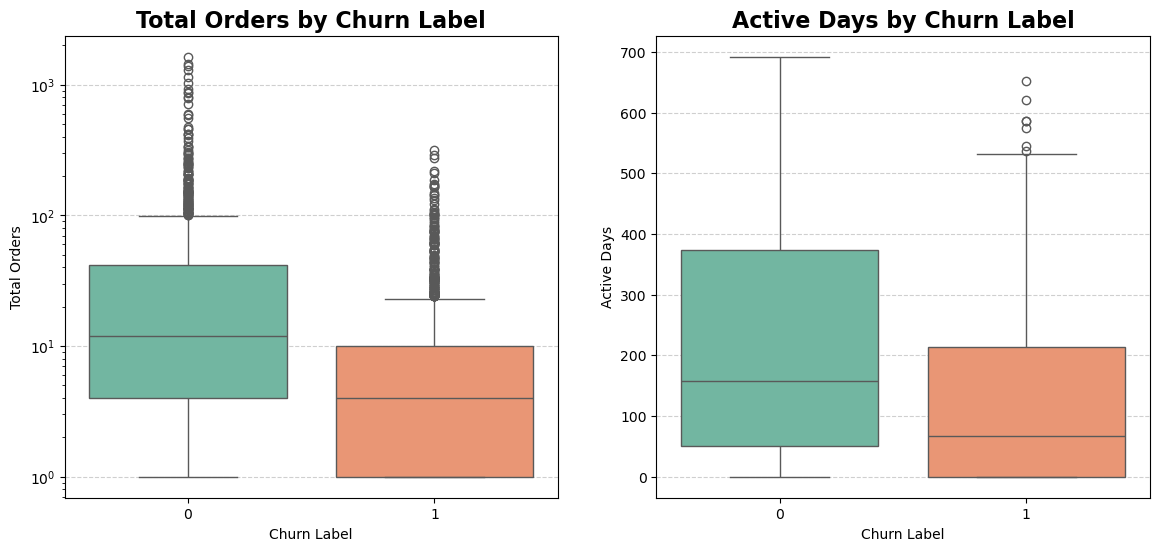

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total Orders vs Churn
sns.boxplot(data=seller_activity, x='churned', y='total_orders', ax=axes[0], palette='Set2')
axes[0].set_yscale('log')
axes[0].set_xlabel('Churn Label')
axes[0].set_ylabel('Total Orders')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].set_title('Total Orders by Churn Label', fontdict={'fontsize': 16,'fontweight' : 'bold'})

# Active Days vs Churn
sns.boxplot(data=seller_activity, x='churned', y='active_days', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Churn Label')
axes[1].set_ylabel('Active Days')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
axes[1].set_title('Active Days by Churn Label', fontdict={'fontsize': 16,'fontweight' : 'bold'})

plt.show()

The boxplots illustrate a consistent behavioral difference between churners and non-churners. In the **left plot**, non-churners clearly show **higher total order volume**, with a significantly higher median and broader upper whisker range. This indicates that sellers who remain active on the platform tend to generate more sales, while churners are clustered around **lower total order counts**, suggesting that **low sales volume strongly correlates with churn**.

The **right plot** further reinforces this observation, showing that **non-churners typically have longer active periods**, with many remaining on the platform for **over 600 days**, while churners often drop off well before the 100-day mark. This behavioral contrast supports the idea that **early engagement and sales momentum are critical to seller retention**. Sellers with stronger starts tend to stay longer, which justifies deeper analysis of their **first 34 days** on the platform.


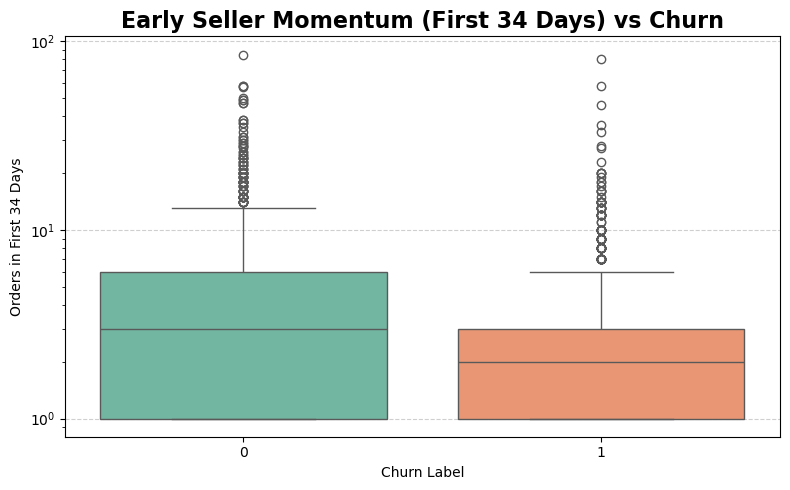

In [93]:
# Define 34-day window per seller
seller_orders['first_order_date'] = seller_orders.groupby('seller_id')['order_purchase_timestamp'].transform('min')
seller_orders['days_since_first_order'] = (seller_orders['order_purchase_timestamp'] - seller_orders['first_order_date']).dt.days

# Filter orders within first 34 days per seller
early_orders = seller_orders[seller_orders['days_since_first_order'] <= churn_threshold]

# Count orders per seller in this window
early_order_counts = early_orders.groupby('seller_id')['order_id'].count().reset_index()
early_order_counts.columns = ['seller_id', 'early_order_count']

# Merge with churn labels
seller_churn_early = pd.merge(seller_activity[['seller_id', 'churned']], early_order_counts, on='seller_id', how='left')
seller_churn_early['early_order_count'] = seller_churn_early['early_order_count'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=seller_churn_early, x='churned', y='early_order_count', palette='Set2')
ax.set_xlabel('Churn Label')
ax.set_ylabel(f'Orders in First {churn_threshold} Days')
ax.set_title(f'Early Seller Momentum (First {churn_threshold} Days) vs Churn', fontdict={'fontsize': 16,'fontweight' : 'bold'})
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.yscale('log')
plt.tight_layout()
plt.show()


Now this boxplot compares early seller activity between churners and non-churners. At a glance, we can see that **the medians are rather close in both groups**, suggesting typical sellers tend to make only a few sales within the first 34 days. However, the **true difference lies in the spread of the upper range**. Non-churners appears to have a much broader distribution, with some achieving higher sales volumes, while **churners remain concentrated at the lower end**. The existence of these high-performing sellers among the non-churning group suggests that early success may play a role in long-term engagement, even if it's not reflected in the median.

Continuing on, let's take a look at the sellers cohort chart.

Remember that we found some months that does not have a complete data (at least 25 unique dates in a month)? Since this is a time sensitive data, we will remove every month that has under 25 unique dates, as that does not seem fair for the cohort visualization.

In [94]:
cohort_df = seller_orders[['seller_id', 'order_purchase_timestamp']].copy()
cohort_df['order_month'] = cohort_df['order_purchase_timestamp'].dt.to_period('M')

# get unique date count for each year-month combo
month_counts = orders_df.groupby(['order_purchase_timestamp_year', 'order_purchase_timestamp_month'])['order_purchase_timestamp_day'].nunique().reset_index()

# combine to YYYY-MM
month_counts['order_month'] = pd.to_datetime({
  'year': month_counts['order_purchase_timestamp_year'],
  'month': month_counts['order_purchase_timestamp_month'],
  'day': 1
}).dt.to_period('M')

# get the incomplete months
incomplete_months = month_counts.loc[month_counts['order_purchase_timestamp_day'] < 25, 'order_month']

# remove incomplete months from cohort_df
cohort_df = cohort_df[~cohort_df['order_month'].isin(incomplete_months)]

cohort_df['cohort_month'] = cohort_df.groupby('seller_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
cohort_df['month_index'] = cohort_df['order_month'].astype('int64') - cohort_df['cohort_month'].astype('int64')

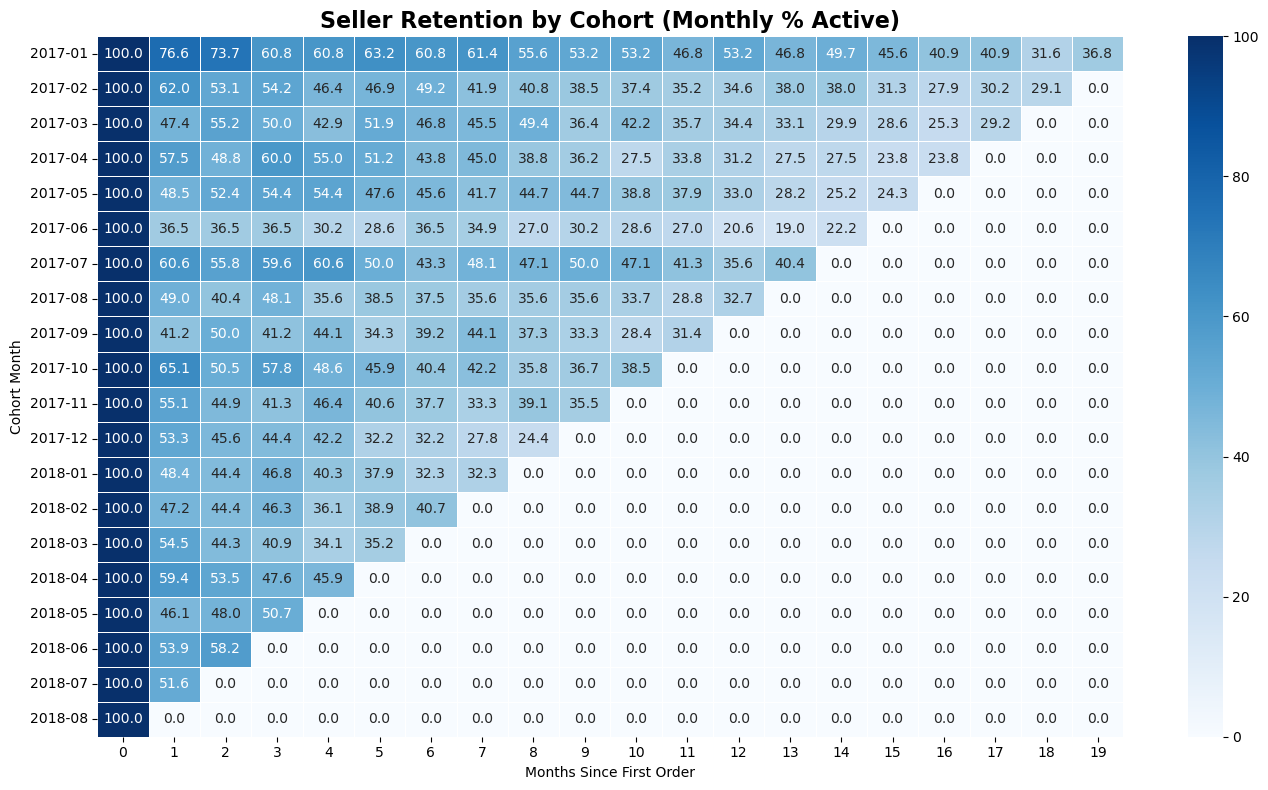

In [95]:
cohort_pivot = cohort_df.groupby(['cohort_month', 'month_index'])['seller_id'].nunique().reset_index().pivot(index='cohort_month', columns='month_index', values='seller_id').fillna(0)

cohort_pivot.columns = cohort_pivot.columns.astype(int)

cohort_sizes = cohort_pivot[0] # get index 0 (starting unique seller count)
retention_pct = cohort_pivot.divide(cohort_sizes, axis=0) * 100

# Step 7: Plot
pltFigsize((14, 8))
sns.heatmap(retention_pct, annot=True, fmt='.1f', cmap='Blues', linewidths=0.5, linecolor='white')
pltTitle('Seller Retention by Cohort (Monthly % Active)')
plt.xlabel('Months Since First Order')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

The cohort map highlights clear differences in seller retention over time. Sellers who joined in early 2017, especially between January and May, demonstrate stronger long-term engagement, with many maintaining over **40–60% activity for several consecutive months**. In contrast, more recent cohorts show a steeper decline — often dipping below **50% retention as early as month 2 or 3**. This suggests newer sellers may be struggling more to gain traction or facing different onboarding challenges than earlier groups.

Overall, the heatmap reinforces a key insight: **early-stage churn dominates**, with most sellers exiting within the first few months. If a seller remains active beyond month 3, they’re far more likely to continue. However, we've previously defined the churn threshold to be 34 days of inactivity, this can also be seen in this chart with a trend of sharp falls within the first month for most of the group.

Moving on, lets dive deeper to find out what drives a seller to churn (or not).

### **Product Metrics**

In [96]:
# Calculate both average and median product prices per seller
price_stats = (
  order_items_df
  .groupby('seller_id')['price']
  .agg(avg_price='mean', median_price='median')
  .reset_index()
)

# Merge into seller activity to include churn labels
seller_price_df = pd.merge(seller_activity, price_stats, on='seller_id', how='left')

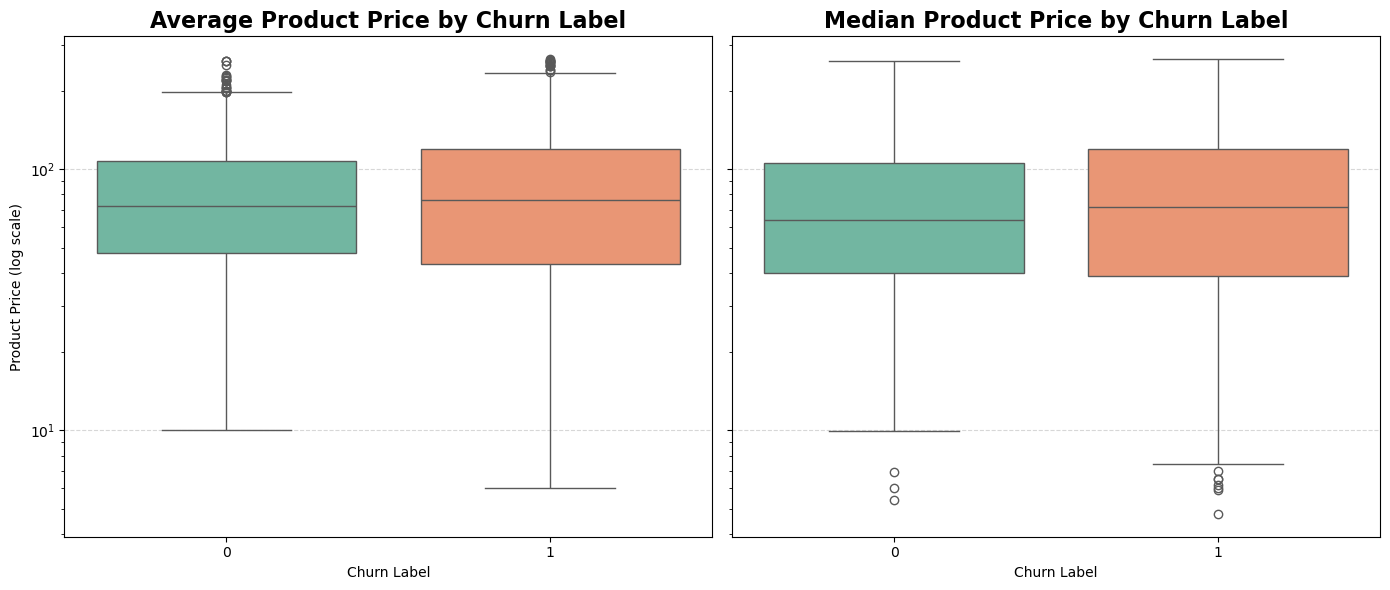

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Average Price Plot
sns.boxplot(data=seller_price_df, x='churned', y='avg_price', palette='Set2', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Churn Label')
axes[0].set_ylabel('Product Price (log scale)')
axes[0].set_title('Average Product Price by Churn Label', fontdict={'fontsize': 16, 'fontweight': 'bold'})
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Median Price Plot
sns.boxplot(data=seller_price_df, x='churned', y='median_price', palette='Set2', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('Churn Label')
axes[1].set_title('Median Product Price by Churn Label', fontdict={'fontsize': 16, 'fontweight': 'bold'})
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


The boxplots above compare **average and median product prices** between churned and non-churned sellers. In both charts, we can see that **churned sellers tend to have slightly higher median and average prices** than their non-churned counterparts. Although the overall distributions are fairly similar, the churned group skews a bit higher, especially in the upper half of the box.

Interestingly, both groups have comparable spread and outliers — particularly in the lower price range — but the churned group has a slightly **longer lower whisker** in the median chart. This subtle price difference may suggest that **pricing strategy plays a role in retention**, where sellers pricing themselves above the market average might face more churn risk, possibly due to reduced competitiveness or slower sales.

That said, this feature alone likely isn’t decisive, but it adds meaningful signal when combined with other behavioral and transactional patterns in a churn prediction model.

Next, let's look at product categories

In [98]:
# Merge order items with product master category
order_items_categ = order_items_df.merge(products_df[['product_id', 'product_master_category_name']], on='product_id', how='inner')

# Identify top master category per seller
top_master_category_per_seller = (order_items_categ
	.groupby(['seller_id', 'product_master_category_name'])
	.size()
  .reset_index(name='count')
  .sort_values(['seller_id', 'count'], ascending=[True, False])
  .drop_duplicates('seller_id')
  .rename(columns={'product_master_category_name': 'top_master_category'})
)

# Merge with seller_activity
seller_category_df = pd.merge(
  seller_activity,
  top_master_category_per_seller[['seller_id', 'top_master_category']],
  on='seller_id', how='inner'
)

# Group by churn status
category_churn_counts = (
  seller_category_df
  .groupby(['top_master_category', 'churned'])
  .size()
  .unstack(fill_value=0)
  .rename(columns={0: 'Non-Churned', 1: 'Churned'})
)

# Calculate totals and churn rate
category_churn_counts['Total'] = category_churn_counts.sum(axis=1)
category_churn_counts['Churn Rate (%)'] = (
  category_churn_counts['Churned'] / category_churn_counts['Total'] * 100
)

top_10 = category_churn_counts.sort_values('Total', ascending=False).head(10)

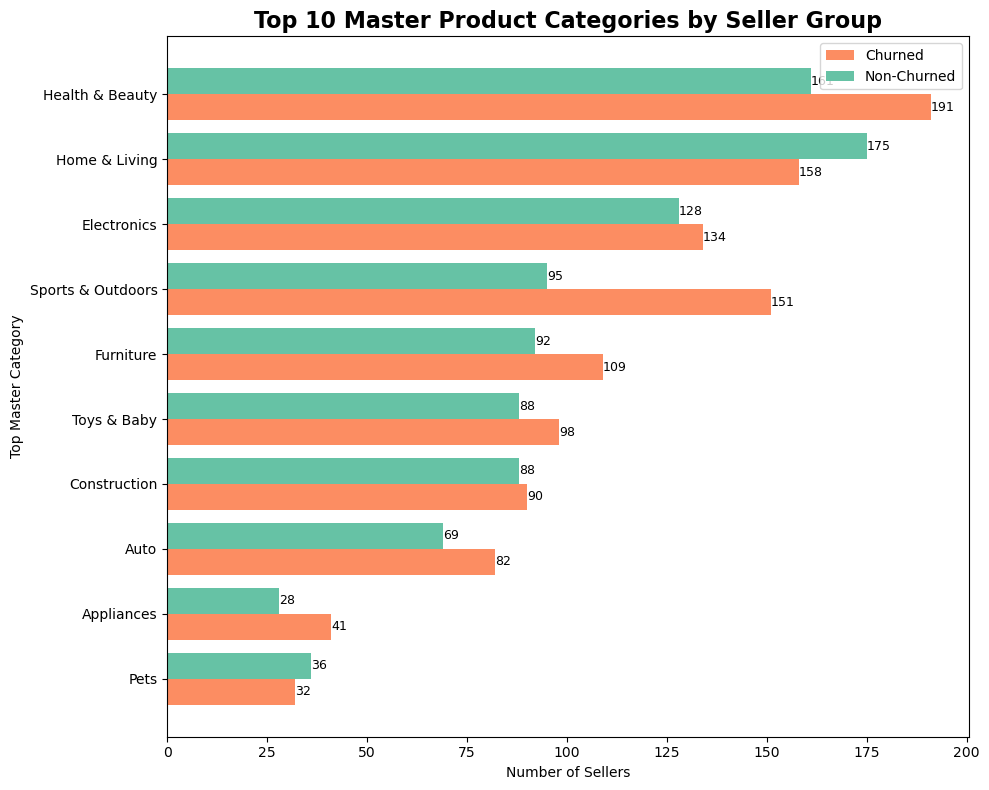

In [99]:
# Plot
categories = top_10.index
churned = top_10['Churned']
non_churned = top_10['Non-Churned']
y = range(len(categories))
bar_height = 0.4

pltFigsize((10, 8))

plt.barh(y=[i + bar_height/2 for i in y], width=churned, height=bar_height, label='Churned', color='#fc8d62')
plt.barh(y=[i - bar_height/2 for i in y], width=non_churned, height=bar_height, label='Non-Churned', color='#66c2a5')

# Labels
for i, (c, nc) in enumerate(zip(churned, non_churned)):
  plt.text(c, i + bar_height/2, f'{c:.0f}', va='center', ha='left', fontsize=9, color='black')
  plt.text(nc, i - bar_height/2, f'{nc:.0f}', va='center', ha='left', fontsize=9, color='black')

plt.yticks(ticks=y, labels=categories)
plt.xlabel('Number of Sellers')
plt.ylabel('Top Master Category')
plt.legend()
pltTitle('Top 10 Master Product Categories by Seller Group')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

This bar chart displays the **top 10 master product categories** by number of sellers, divided into churned and non-churned groups. Most categories — such as `Health & Beauty`, `Home & Living`, and `Electronics` — are relatively balanced in churn distribution, though churned sellers tend to slightly outnumber their counterparts in a few cases.

A standout case is `Sports & Outdoors`, where churned sellers **clearly dominate**, suggesting potential challenges in that category. Meanwhile, categories like `Auto`, `Appliances`, and `Pets` show slightly more stable engagement. Still, since this chart reflects **raw counts**, it's not enough to assess churn risk accurately. We'll follow up with a **percentage-based churn rate** to reveal which categories actually carry higher churn likelihoods.


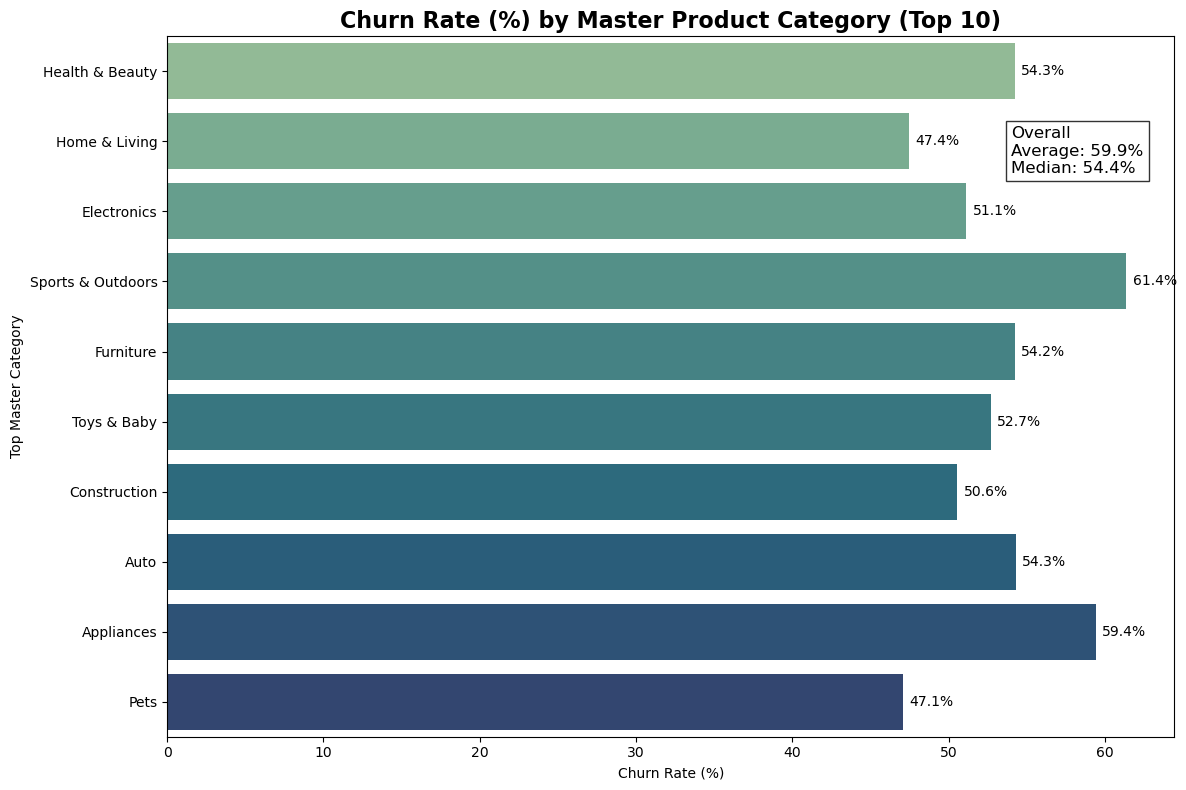

In [100]:
# Calculate mean/median churn rate of top 10
mean_churn = category_churn_counts['Churn Rate (%)'].mean()
median_churn = category_churn_counts['Churn Rate (%)'].median()

# Plot
pltFigsize((12, 8))
ax = sns.barplot(
  y=top_10.index,
  x='Churn Rate (%)',
  data=top_10,
  palette='crest'
)

# Annotate each bar with percentage
for i, v in enumerate(top_10['Churn Rate (%)']):
  ax.text(v + 0.4, i, f'{v:.1f}%', va='center', color='black')

# Add average/median info as annotation box
plt.text(x=54, y=1.45, s=f'Overall\nAverage: {mean_churn:.1f}%\nMedian: {median_churn:.1f}%', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

pltTitle('Churn Rate (%) by Master Product Category (Top 10)')
plt.xlabel('Churn Rate (%)')
plt.ylabel('Top Master Category')
plt.tight_layout()
plt.show()

We can see that at the top of the list, categories like **Sports & Outdoors (61.4%)** and **Appliances (59.4%)** show significantly higher churn rates than average, indicating these segments may carry elevated risk for seller dropout. Even widely represented categories such as **Auto**, **Health & Beauty**, and **Furniture** hover around or slightly above the overall median churn rate of **54.4%**.

Interestingly, categories like **Electronics**, **Construction**, and **Home & Living** have churn rates that fall just below the median, suggesting slightly stronger seller retention in those areas despite being heavily saturated. **Pets**, which rounds out the top 10, shows the lowest churn rate in this group at **47.1%**, hinting that niche markets may offer better long-term engagement. Overall, this breakdown gives a clearer picture of where seller turnover is most pronounced and where support or optimization efforts might have the highest impact.

Now, we figured out a lot of stuff, the next question is: **how well are they serving customers?** A seller’s ability to deliver quality service is often reflected in the **reviews they receive** — especially in a marketplace environment like Olist’s. If churned sellers tend to get lower ratings or more negative feedback, it could signal that **customer satisfaction plays a key role in retention**. Let’s dive into the review score patterns to see what they reveal.

### **Customer Reviews**

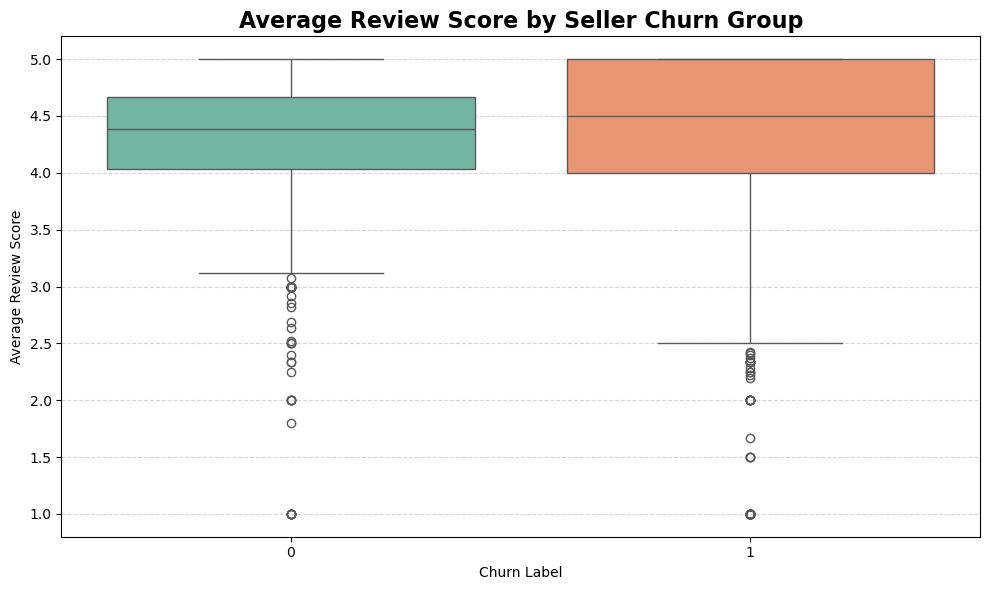

In [101]:
review_items = order_reviews_df.merge(order_items_df[['order_id', 'seller_id']], on='order_id', how='left')

review_items = review_items.dropna(subset=['seller_id'])

avg_review_per_seller = review_items.groupby('seller_id')['review_score'].mean().reset_index().rename(columns={'review_score': 'avg_review_score'})

seller_review_df = pd.merge(seller_activity, avg_review_per_seller, on='seller_id', how='left')

pltFigsize((10, 6))
sns.boxplot(data=seller_review_df, x='churned', y='avg_review_score', palette='Set2')
pltTitle('Average Review Score by Seller Churn Group')
plt.xlabel('Churn Label')
plt.ylabel('Average Review Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

A rather surprising finding we have here. Our initial thoughts of ***'churners must've had bad reviews'*** is completely wiped out. The **median review score for churned sellers is slightly higher** than that of the non-churned group. Both distributions span the same general range, but churned sellers show a longer lower tail with more outliers below 3. This suggests that **a few bad reviews may occur more often among churned sellers**, but they don’t appear frequently enough to affect the group’s median negatively.

This plot doesn’t support the idea that **review score is a strong influence** towards sellers churn rate. To figure out more, let's see the geographical data.

### **Geospatial Influece**

In [102]:
seller_geo = sellers_df.merge(seller_activity[['seller_id', 'churned']], on='seller_id', how='left')
seller_geo = seller_geo.merge(geolocation_df.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index(),
                              left_on='seller_zip_code_prefix',
                              right_on='geolocation_zip_code_prefix',
                              how='left')

seller_geo = seller_geo.dropna(subset=['geolocation_lat', 'geolocation_lng'])

In [103]:
map_center = [-17.607454304862127, -47.28672171748872]
brazil_map = folium.Map(location=map_center, zoom_start=4.5, tiles='cartodbpositron')

colors = {0: 'green', 1: 'red'}
labels = {0: 'Non-Churned', 1: 'Churned'}

for churn_status in [0, 1]:
  subset = seller_geo[seller_geo['churned'] == churn_status]
  for _, row in subset.iterrows():
    folium.CircleMarker(
      location=[row['geolocation_lat'], row['geolocation_lng']],
      radius=2,
      color=colors[churn_status],
      fill=True,
      fill_opacity=0.6,
      popup=labels[churn_status]
    ).add_to(brazil_map)

folium.LayerControl().add_to(brazil_map)

brazil_major_cities = [
  {'name': 'São Paulo', 'lat': -23.5505, 'lng': -46.6333, 'color': 'darkblue'},
  {'name': 'Rio de Janeiro', 'lat': -22.9068, 'lng': -43.1729, 'color': 'darkblue'},
  {'name': 'Belo Horizonte', 'lat': -19.9167, 'lng': -43.9345, 'color': 'blue'},
  {'name': 'Curitiba', 'lat': -25.4284, 'lng': -49.2733, 'color': 'blue'},
  {'name': 'Porto Alegre', 'lat': -30.0346, 'lng': -51.2177, 'color': 'blue'},
  {'name': 'Guarulhos', 'lat': -23.4545, 'lng': -46.5333, 'color': 'darkblue'},
  {'name': 'Campinas', 'lat': -22.9099, 'lng': -47.0626, 'color': 'darkblue'},
]

for city in brazil_major_cities:
	folium.Marker(
		location=[city['lat'], city['lng']],
		tooltip=city['name'],
		icon=folium.Icon(
			color=city['color'],
			icon='info-sign'
		)
	).add_to(brazil_map)

brazil_map

By looking at the geographical data, we can see that churns are not happening at random. Major cities, marked in dark blue, aligns with common knowledge where most business happens, hence the cluster of sellers. However, theres a noticeable cluster of **red marks (churned sellers)** surrounding major cities, suggesting that urban/metropolitan area is where the competition thickens. While **green marks (non-churned sellers)** are also present in large numbers, they appear to be more balanced and dispersed. In crowded areas, **sellers may struggle with competition** such as visibility, pricing wars, and/or higher customer expectations.

Further from the central area, we can see **sellers are rather sparse**. In the northern region, certain sellers are actively engaging with the platform but **experiencing limited success**, as evidenced by a higher number of red marks compared to green marks in more remote areas. **These areas might benefit from support**, offering Olist an opportunity to capitalize on the untapped markets.

Having explored the geographic spread of sellers across Brazil, it's clear that seller concentration varies widely between major cities and rural regions. This naturally raises the question: **does geography impact delivery reliability — and could that, in turn, influence seller churn?** Let’s investigate this by comparing delivery delays across churn groups.

### **Delivery Performance**

In [104]:
# Compute churn status
last_order = merged_df.groupby('seller_id')['order_purchase_timestamp'].max().reset_index()
last_order.columns = ['seller_id', 'last_order_date']
overall_last_date = merged_df['order_purchase_timestamp'].max()
last_order['inactive_days'] = (overall_last_date - last_order['last_order_date']).dt.days
last_order['churned'] = (last_order['inactive_days'] > churn_threshold).astype(int)

# Merge churn info back into merged_df
merged_df = merged_df.merge(last_order[['seller_id', 'churned']], on='seller_id', how='left')

# Calculate delivery delay (positive = late, negative = early)
merged_df['delivery_delay'] = (
  merged_df['order_delivered_customer_date'] - merged_df['order_estimated_delivery_date']
).dt.days

# Filter valid rows
delay_df = merged_df.dropna(subset=['delivery_delay', 'churned', 'seller_id'])

# Aggregate average delay per seller
seller_delay = (
  delay_df
  .groupby('seller_id')
  .agg(avg_delay=('delivery_delay', 'mean'), churned=('churned', 'first'))
  .reset_index()
)

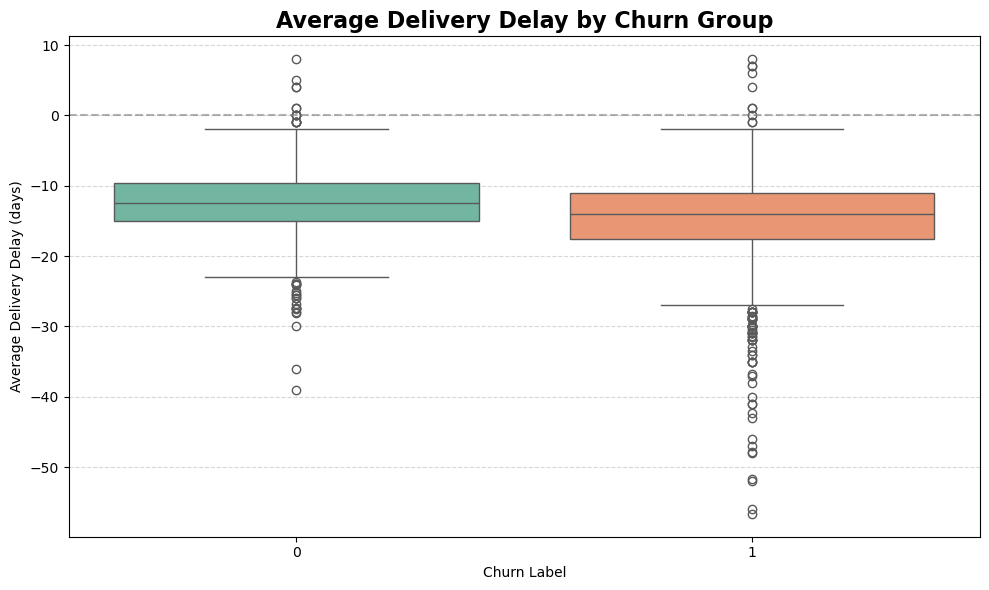

In [105]:
# Plot
pltFigsize((10, 6))
sns.boxplot(data=seller_delay, x='churned', y='avg_delay', palette='Set2')
plt.axhline(0, linestyle='--', color='gray', alpha=0.6)
pltTitle('Average Delivery Delay by Churn Group')
plt.xlabel('Churn Label')
plt.ylabel('Average Delivery Delay (days)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The plot above shows the **Average Delivery Delay** of each seller in each group. We can see that **sellers in both group typically deliver earlier than expected**, with the median below 0 days, which is great. However, a closer look shows that while churned sellers have a slightly **wider spread** in delivery delay, their **median is nearly identical** to non-churners, and the **upper whiskers and outliers are not meaningfully more extreme**. This suggests that **lateness alone doesn’t explain churn**.

However, the broader spread among churned sellers **could indicate less consistency** in delivery performance. It's not about being late all the time — it’s about being **unpredictable**. This inconsistency may affect customer trust and experience, potentially contributing to churn in more subtle ways. So the story may not be about delays, but about **reliability**. A next step could be comparing **standard deviation** of delivery times to test this hypothesis.

In [106]:
seller_delivery_stats = delay_df.groupby('seller_id').agg(avg_delay=('delivery_delay', 'mean'), std_delay=('delivery_delay', 'std'), churned=('churned', 'first')).reset_index()

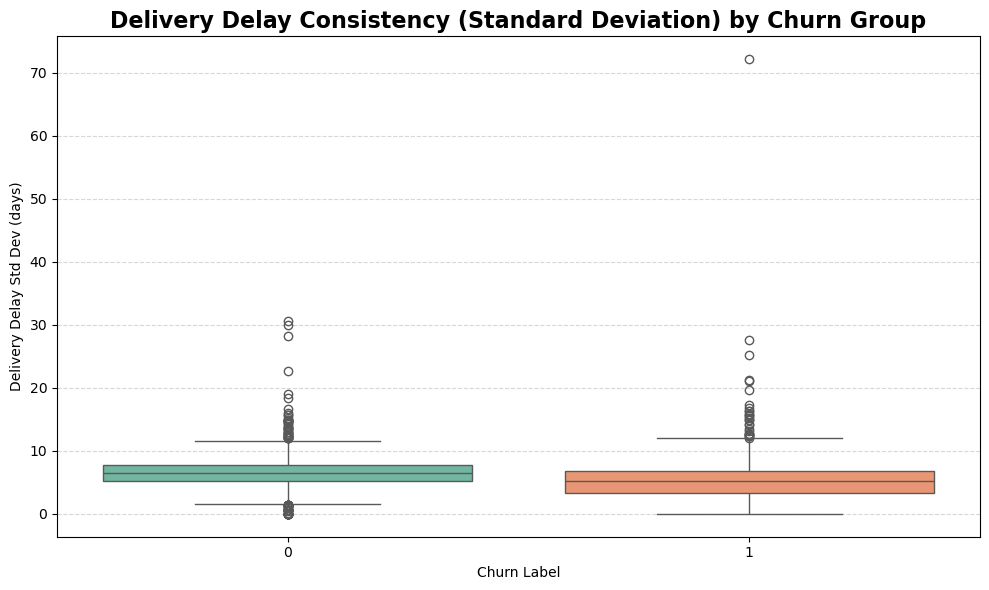

In [107]:
pltFigsize((10, 6))
sns.boxplot(data=seller_delivery_stats, x='churned', y='std_delay', palette='Set2')
pltTitle('Delivery Delay Consistency (Standard Deviation) by Churn Group')
plt.xlabel('Churn Label')
plt.ylabel('Delivery Delay Std Dev (days)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The boxplot reveals that **churned sellers have lower standard deviation** in their delivery delay compared to non-churned sellers. This suggests that their delivery performance is actually **more consistent**, not less (aside from one outlier). The spread of the non-churned group is noticeably wider, indicating greater variability in how early or late they deliver. This challenges the assumption that inconsistency is a key churn driver — at least based on delivery timing alone. Delivery reliability does not appear to be a differentiating factor in churn based on this metric.

Now that we’ve explored delivery timing and consistency, another factor worth investigating is **freight cost**. High or inconsistent shipping charges could deter buyers, reduce conversion rates, and potentially lead to lower sales — which in turn might affect seller retention. Let’s compare **average freight value per seller** across churn groups to see if there’s a pricing pattern.

In [108]:
# Prepare data
freight_df = merged_df.dropna(subset=['freight_value', 'churned'])

seller_freight = (
  freight_df
  .groupby('seller_id')
  .agg(
    avg_freight=('freight_value', 'mean'),
    median_freight=('freight_value', 'median'),
    churned=('churned', 'first')
  )
  .reset_index()
)

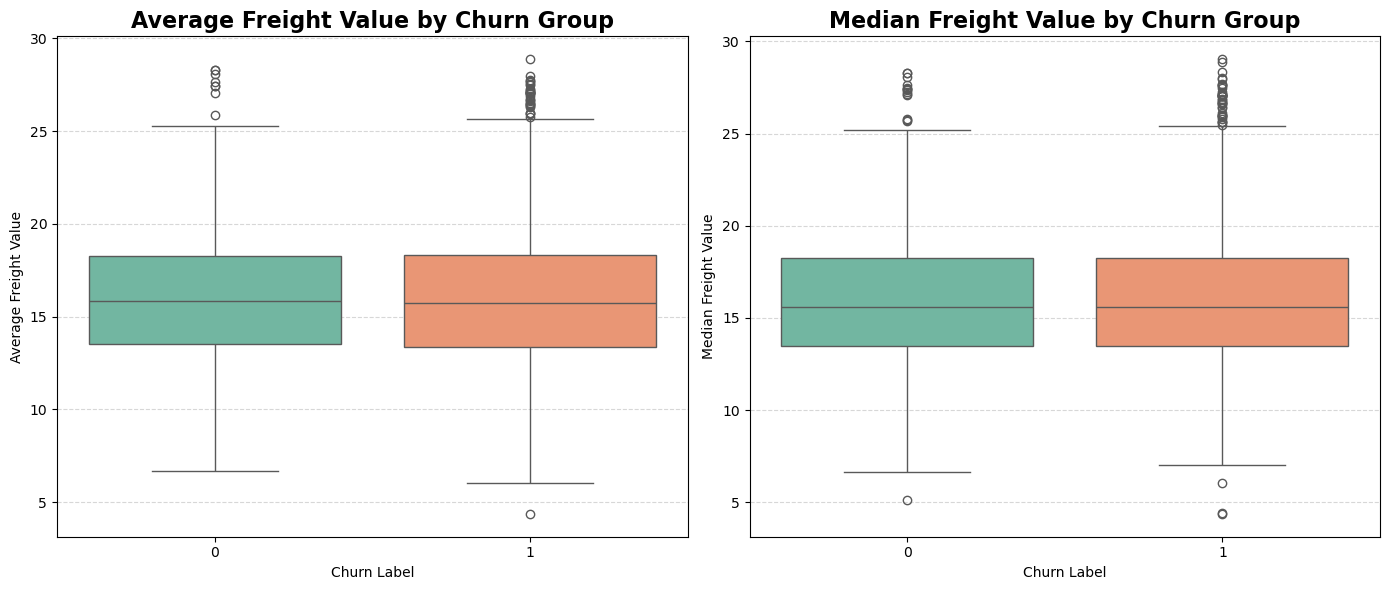

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=seller_freight, x='churned', y='avg_freight', palette='Set2', ax=axes[0])
axes[0].set_title('Average Freight Value by Churn Group', fontdict={'fontsize': 16, 'fontweight': 'bold'})
axes[0].set_xlabel('Churn Label')
axes[0].set_ylabel('Average Freight Value')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

sns.boxplot(data=seller_freight, x='churned', y='median_freight', palette='Set2', ax=axes[1])
axes[1].set_title('Median Freight Value by Churn Group', fontdict={'fontsize': 16, 'fontweight': 'bold'})
axes[1].set_xlabel('Churn Label')
axes[1].set_ylabel('Median Freight Value')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The boxplots show that **both average and median freight values are almost indistinguishable between churned and non-churned sellers**. Medians are closely aligned, and the interquartile ranges — along with the upper whiskers and outlier patterns — are very similar for both groups. This consistent similarity across both average and median measures suggests that **freight pricing is not a significant factor in determining seller churn**.

If anything, the churned group displays a slightly broader lower whisker and more mild outliers on the lower end, but the differences are negligible. Overall, these results reinforce that **freight value is not a meaningful predictor of churn**, shifting our attention to other possible explanations such as **customer payment behavior**, **installment trends**, or **overall transaction value**. Let’s explore that next.

### **Payments**

In [110]:
# Calculate average and median payment value per seller
payment_stats_df = (
  merged_df
  .groupby('seller_id')['payment_value']
  .agg(avg_payment_value='mean', median_payment_value='median')
  .reset_index()
)

# Merge with churn labels
payment_stats_df = payment_stats_df.merge(
  seller_activity[['seller_id', 'churned']],
  on='seller_id', how='inner'
)

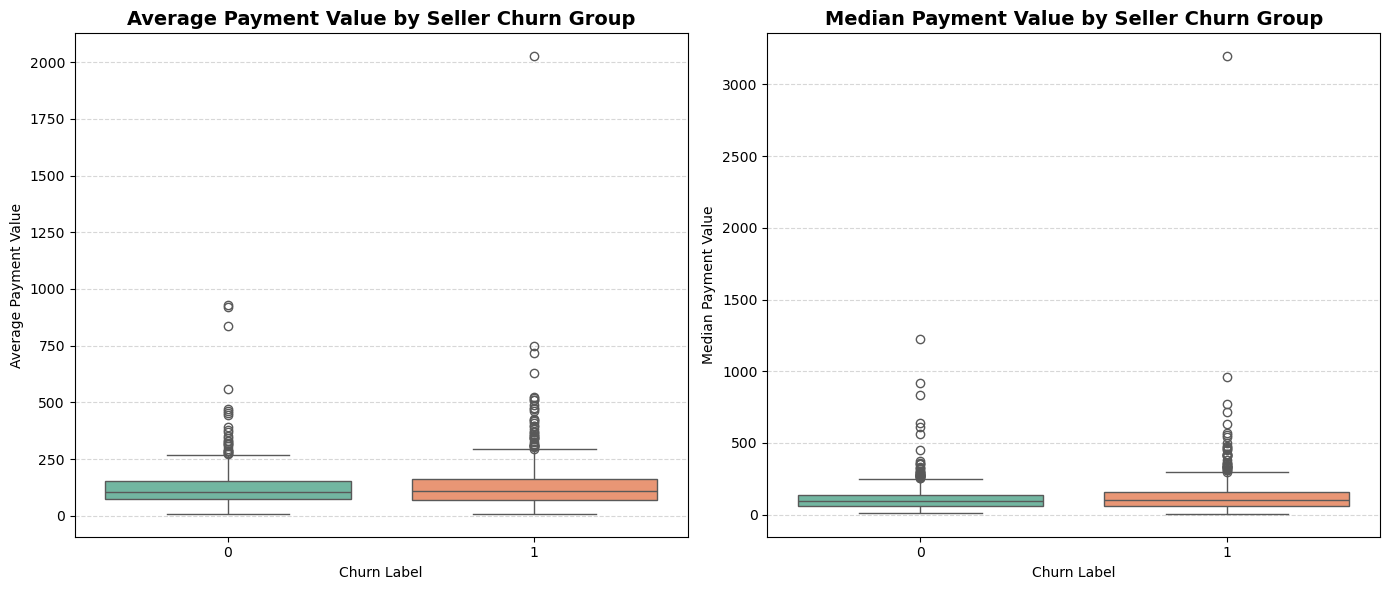

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
  data=payment_stats_df,
  x='churned', y='avg_payment_value',
  palette='Set2', ax=axes[0]
)
axes[0].set_title('Average Payment Value by Seller Churn Group', fontdict={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_xlabel('Churn Label')
axes[0].set_ylabel('Average Payment Value')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

sns.boxplot(
  data=payment_stats_df,
  x='churned', y='median_payment_value',
  palette='Set2', ax=axes[1]
)
axes[1].set_title('Median Payment Value by Seller Churn Group', fontdict={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_xlabel('Churn Label')
axes[1].set_ylabel('Median Payment Value')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The boxplot comparing **average and median payment value** between churned and non-churned sellers reveals a **surprisingly similar distribution**. Both groups show similar interquartile ranges, with churned sellers having a slightly wider spread and marginally lower median payment values. Although the non-churned group has more extreme outliers (going above 2000), these are rare cases. Overall, payment value alone does not appear to distinguish the two groups sharply — suggesting that higher or lower average transaction values may not directly correlate with seller churn behavior.

But perhaps payment structure may have something to say. Let’s focus on **installment usage**, which might reveal deeper patterns about buyer behavior and how it may influence seller retention.


In [112]:
installments_stats = (
  merged_df
  .groupby(['seller_id', 'churned'])['payment_installments']
  .agg(avg_installments='mean', median_installments='median')
  .reset_index()
)

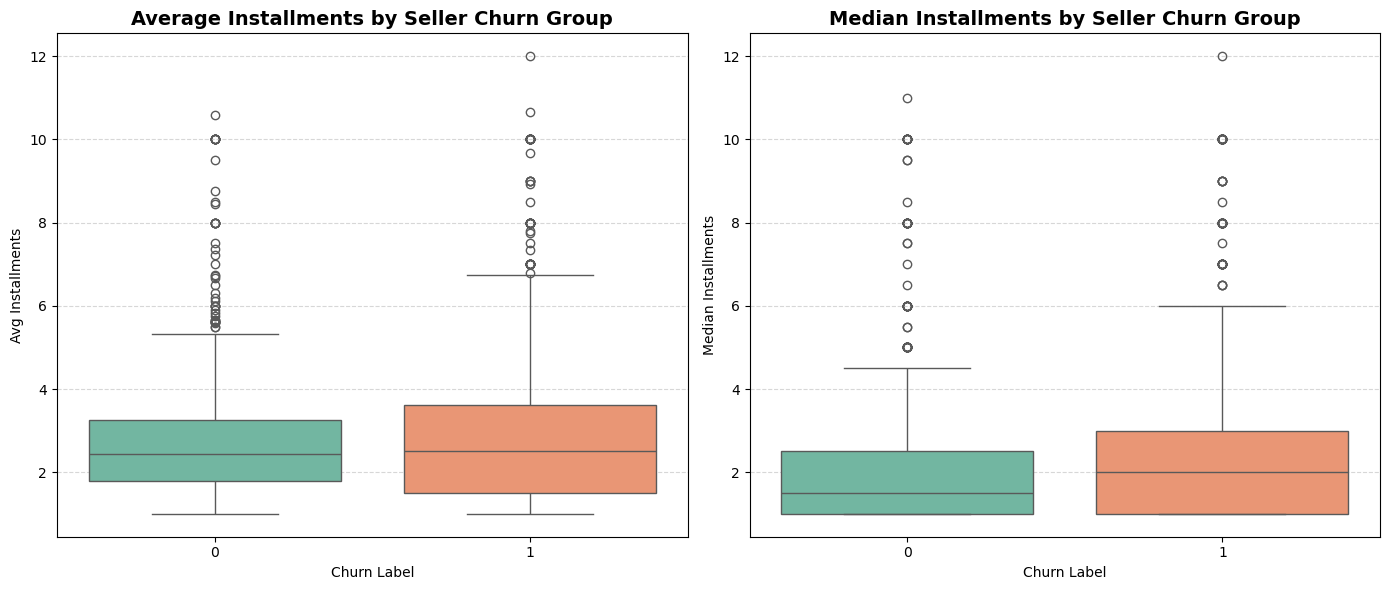

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Average installments
sns.boxplot(
  data=installments_stats,
  x='churned', y='avg_installments',
  palette='Set2', ax=axes[0]
)
axes[0].set_title('Average Installments by Seller Churn Group', fontdict={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_xlabel('Churn Label')
axes[0].set_ylabel('Avg Installments')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Median installments
sns.boxplot(
  data=installments_stats,
  x='churned', y='median_installments',
  palette='Set2', ax=axes[1]
)
axes[1].set_title('Median Installments by Seller Churn Group', fontdict={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_xlabel('Churn Label')
axes[1].set_ylabel('Median Installments')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


The plots above explore the **distribution of average and median payment installments** by seller churn group. Both churned and non-churned sellers cluster around a similar central point — roughly 2 to 2.5 installments — indicating that installment usage is relatively modest across the board.

However, the key difference lies in the spread: **churned sellers display a wider distribution**, with more variance and higher outliers, especially in the average installment plot. This suggests some churned sellers might rely more heavily on longer installment periods, potentially as a signal of targeting lower purchasing power segments. **Non-churners, on the other hand, exhibit tighter dispersion**, showing more consistent payment behavior.

While the differences aren’t drastic, this adds another piece of the puzzle — installment strategy may play a minor role in seller retention, especially when compounded with other risk factors. Let’s continue by examining the **types of payment methods** used.

In [114]:
seller_orders = order_items_df[['order_id', 'seller_id']].drop_duplicates()

payments = seller_orders.merge(
	merged_df[['seller_id', 'churned']].drop_duplicates(),
	on='seller_id', how='left'
).merge(
	order_payments_df[['order_id', 'payment_type']],
	on='order_id', how='left'
)

payment_counts = pd.crosstab(payments['payment_type'], payments['churned'])

payment_pct = payment_counts.div(payment_counts.sum(axis=1), axis=0) * 100

<Figure size 1000x600 with 0 Axes>

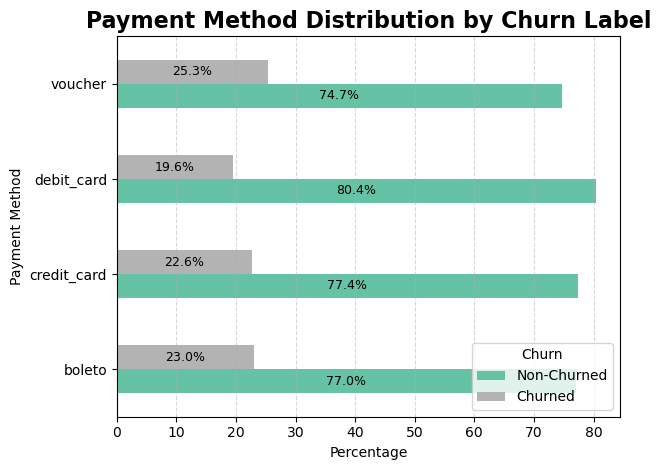

In [115]:
pltFigsize((10, 6))

ax = payment_pct.plot(kind='barh', colormap='Set2')

# Add labels
for i, bars in enumerate(ax.containers):
	for bar in bars:
		width = bar.get_width()
		y_pos = bar.get_y() + bar.get_height() / 2
		if width < 10:
			# Label near the right end
			x_pos = bar.get_x() + width + 1
			ha = 'left'
		else:
			# Center label inside bar
			x_pos = bar.get_x() + width / 2
			ha = 'center'
		ax.text(x_pos, y_pos, f'{width:.1f}%', ha=ha, va='center', fontsize=9, color='black')

pltTitle('Payment Method Distribution by Churn Label')
plt.xlabel('Percentage')
plt.ylabel('Payment Method')
plt.legend(title='Churn', labels=['Non-Churned', 'Churned'], loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

This chart breaks down the **churn distribution across different payment methods**. The first thing we notice is that **churned sellers consistently represent the minority** in each category — never exceeding 26%. Payment types like `debit_card` and `credit_card` are especially skewed, with over 77% of associated sellers remaining active.

While this doesn’t necessarily imply causation, it hints that **more stable sellers tend to be associated with card-based payments**, possibly reflecting more reliable or established buyer behavior. On the other hand, churned sellers appear slightly more represented in `voucher` and `boleto`, which may correlate with more price-sensitive or less frequent buyers. However, the differences aren’t large, and overall, **payment method alone is likely not a strong predictor of churn**, though it may support patterns seen elsewhere.

## **> Machine Learning**
<hr>

In [327]:
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipe

# Column Transformer
from sklearn.compose import ColumnTransformer

# Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# Missing Values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Imbalance
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import FunctionTransformer

# Cross Validation
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# modeling -> ensemble
# -> Various
from sklearn.ensemble import VotingClassifier, StackingClassifier
# -> Similar
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# feature selection
from sklearn.feature_selection import SelectFromModel

# Confusion Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score

# SHAP
import shap

# Pickle
import pickle

### **Data Frame Setup**

In [328]:
# Base seller-level aggregations
ml_df = (
  merged_df.groupby('seller_id').agg(
    total_orders=('order_id', 'nunique'),
    active_days=('order_purchase_timestamp', lambda x: (x.max() - x.min()).days),
    avg_product_price=('price', 'mean'),
    median_product_price=('price', 'median'),
    avg_freight_value=('freight_value', 'mean'),
    median_freight_value=('freight_value', 'median'),
    avg_product_volume=('product_volume_cm3', 'mean'),
    avg_review_score=('review_score', 'mean'),
    median_review_score=('review_score', 'median'),
    avg_delivery_delay=('order_delivered_customer_date', lambda x: (x - merged_df.loc[x.index, 'order_estimated_delivery_date']).dt.days.mean()),
    last_order_date=('order_purchase_timestamp', 'max')
  ).reset_index()
)

# Installments and payment types
seller_orders = order_items_df[['order_id', 'seller_id']].drop_duplicates()

# Avg installments
installments_avg = (
  seller_orders.merge(order_payments_df[['order_id', 'payment_installments']], on='order_id', how='inner')
  .groupby('seller_id')['payment_installments']
  .mean()
  .reset_index(name='avg_installments')
)
ml_df = ml_df.merge(installments_avg, on='seller_id', how='inner')

# One-hot payment types
payment_types = (
  seller_orders.merge(order_payments_df[['order_id', 'payment_type']], on='order_id', how='inner')
)
payment_dummies = pd.get_dummies(payment_types['payment_type'], prefix='payment_type')
payment_combined = pd.concat([payment_types[['seller_id']], payment_dummies], axis=1)
payment_flags = payment_combined.groupby('seller_id').max().reset_index()
ml_df = ml_df.merge(payment_flags, on='seller_id', how='inner').fillna(0).astype({
  'payment_type_credit_card': 'int',
  'payment_type_debit_card': 'int',
  'payment_type_boleto': 'int',
  'payment_type_voucher': 'int'
})

# Top-selling master category
order_items_categ = order_items_df.merge(products_df[['product_id', 'product_master_category_name']], on='product_id', how='inner')
top_category = (
  order_items_categ.groupby(['seller_id', 'product_master_category_name'])
  .size()
  .reset_index(name='count')
  .sort_values(['seller_id', 'count'], ascending=[True, False])
  .drop_duplicates('seller_id')
  .rename(columns={'product_master_category_name': 'top_master_category'})[['seller_id', 'top_master_category']]
)
ml_df = ml_df.merge(top_category, on='seller_id', how='inner')

# Cohort features
seller_first_order = (
  merged_df.groupby('seller_id')['order_purchase_timestamp']
  .min()
  .reset_index(name='first_order_date')
)
seller_first_order['cohort_month'] = seller_first_order['first_order_date'].dt.to_period('M').astype(str)
ml_df = ml_df.merge(seller_first_order[['seller_id', 'cohort_month']], on='seller_id', how='inner')

# Zip code density
seller_density = sellers_df.groupby('seller_zip_code_prefix').size().reset_index(name='seller_density')
seller_zip_density = sellers_df[['seller_id', 'seller_zip_code_prefix']].merge(seller_density, on='seller_zip_code_prefix', how='inner')
ml_df = ml_df.merge(seller_zip_density[['seller_id', 'seller_density']], on='seller_id', how='inner')

# Delivery delay std dev
delivery_std = (
  merged_df.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])
  .assign(delivery_delay=lambda df: (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days)
  .groupby('seller_id')['delivery_delay']
  .std()
  .reset_index(name='std_delivery_delay')
)
ml_df = ml_df.merge(delivery_std, on='seller_id', how='inner')

# Monthly order consistency
merged_df['order_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')
monthly_orders = (
  merged_df.groupby(['seller_id', 'order_month'])['order_id']
  .nunique()
  .reset_index(name='orders_in_month')
)
std_orders = monthly_orders.groupby('seller_id')['orders_in_month'].std().reset_index(name='std_orders_per_month')
ml_df = ml_df.merge(std_orders, on='seller_id', how='inner')

# Product mix diversity
product_mix = (
  order_items_df.merge(products_df[['product_id', 'product_master_category_name']], on='product_id', how='inner')
  .groupby('seller_id')['product_master_category_name']
  .nunique()
  .reset_index(name='unique_categories_sold')
)
ml_df = ml_df.merge(product_mix, on='seller_id', how='inner')

# Avg price per category
avg_price_cat = (
  order_items_df.merge(products_df[['product_id', 'product_master_category_name']], on='product_id', how='inner')
  .groupby('seller_id')
  .apply(lambda x: x.groupby('product_master_category_name')['price'].mean().mean())
  .reset_index(name='avg_price_per_category')
)
ml_df = ml_df.merge(avg_price_cat, on='seller_id', how='inner')

# Review score distribution
review_dist = (
  merged_df[['seller_id', 'review_score']]
  .dropna()
  .groupby(['seller_id', 'review_score'])
  .size()
  .unstack(fill_value=0)
  .apply(lambda x: x / x.sum(), axis=1)
  .add_prefix('review_pct_')
  .reset_index()
)
ml_df = ml_df.merge(review_dist, on='seller_id', how='inner')

# Early momentum
first_orders = merged_df.groupby('seller_id')['order_purchase_timestamp'].min().reset_index(name='first_order_date')
merged_early = merged_df.merge(first_orders, on='seller_id', how='inner')
merged_early['days_from_first'] = (merged_early['order_purchase_timestamp'] - merged_early['first_order_date']).dt.days
early_orders = (
  merged_early[merged_early['days_from_first'] <= churn_threshold]
  .groupby('seller_id')['order_id']
  .nunique()
  .reset_index(name=f'early_orders_{churn_threshold}d')
)
ml_df = ml_df.merge(early_orders, on='seller_id', how='inner')

# Avg Order Value
ml_df['avg_order_value'] = ml_df['avg_product_price'] + ml_df['avg_freight_value']

# Churn flag
latest_order_date = merged_df['order_purchase_timestamp'].max()
inactive_days = (latest_order_date - ml_df['last_order_date']).dt.days
ml_df['churned'] = (inactive_days > churn_threshold).astype(int)

ml_df = ml_df.drop(['seller_id', 'last_order_date'], axis=1)

ml_df

total_orders  active_days  avg_product_price  median_product_price  \
0               22          279         114.602941                110.00   
1               36          210          23.656098                 17.90   
2              114          459         113.090902                109.99   
3               10          188          36.434783                 14.80   
4                1            0          98.000000                 98.00   
...            ...          ...                ...                   ...   
2453            21          174          50.283600                 30.05   
2454            12          531          66.085714                 61.10   
2455             5          120         133.990000                129.99   
2456            20          379          98.325000                 87.40   
2457             5            7          45.400000                 29.40   

      avg_freight_value  median_freight_value  avg_product_volume  \
0             17.870294                16.480        23193.882353   
1             13.797561                15.100         8718.829268   
2             17.705639                17.690        14585.037594   
3             10.990870                 9.670         9211.956522   
4             12.080000                12.080         6048.000000   
...                 ...                   ...                 ...   
2453          13.288800                12.840         7179.720000   
2454          16.790000                16.470        13790.285714   
2455          20.908000                20.880        60000.000000   
2456          19.009500                18.165        20867.350000   
2457          15.584000                13.340         6765.200000   

      avg_review_score  median_review_score  avg_delivery_delay  \
0             4.000000                  5.0          -17.176471   
1             4.341463                  5.0          -11.975610   
2             4.300752                  5.0          -14.187970   
3             3.652174                  4.0          -14.000000   
4             5.000000                  5.0          -10.000000   
...                ...                  ...                 ...   
2453          4.240000                  5.0          -14.360000   
2454          4.714286                  5.0          -12.142857   
2455          4.400000                  4.0           -9.000000   
2456          4.000000                  4.0          -13.600000   
2457          3.000000                  3.0          -47.800000   

      avg_installments  payment_type_boleto  payment_type_credit_card  \
0             4.000000                    1                         1   
1             1.461538                    1                         1   
2             3.762590                    1                         1   
3             2.200000                    0                         1   
4             2.000000                    0                         1   
...                ...                  ...                       ...   
2453          1.652174                    1                         1   
2454          3.846154                    1                         1   
2455          4.600000                    0                         1   
2456          3.550000                    0                         1   
2457          2.000000                    1                         1   

      payment_type_debit_card  payment_type_voucher top_master_category  \
0                           0                     0        Construction   
1                           0                     1           Furniture   
2                           0                     1       Home & Living   
3                           0                     0       Home & Living   
4                           0                     0     Health & Beauty   
...                       ...                   ...                 ...   
2453                        0                     1      

**Check for Multicollinearity**

In [329]:
corr_matrix = ml_df.drop(columns=['payment_type_boleto', 'payment_type_credit_card', 'payment_type_debit_card', 'payment_type_voucher', 'top_master_category', 'cohort_month', 'top_master_category']).corr(numeric_only=True, method='spearman').abs()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = (
  upper_tri.stack()
  .reset_index()
  .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
  .query('Correlation > 0.8')
  .sort_values('Correlation', ascending=False)
)

print('Highly correlated feature pairs (>|0.8|):')
display(high_corr_pairs)

Highly correlated feature pairs (>|0.8|):


Feature 1               Feature 2  Correlation
64        avg_product_price         avg_order_value     0.996936
57        avg_product_price  avg_price_per_category     0.974156
246  avg_price_per_category         avg_order_value     0.971004
45        avg_product_price    median_product_price     0.964461
84     median_product_price         avg_order_value     0.962769
86        avg_freight_value    median_freight_value     0.954688
77     median_product_price  avg_price_per_category     0.927592
152        avg_review_score            review_pct_5     0.907123
0              total_orders             active_days     0.856818
12             total_orders    std_orders_per_month     0.855059

In [330]:
# Drop those with high corrs
ml_df = ml_df.drop([
					'avg_order_value', 'avg_price_per_category', 'median_product_price',
					'median_freight_value', 'median_review_score',
					'review_pct_5', 'active_days', 'total_orders'
				], axis=1)


In [331]:
ml_df.to_csv('dataset/ML_feature_set.csv')

### **Data Prep**

In [332]:
# X and y
X = ml_df.drop(columns='churned')
y = ml_df['churned']

In [333]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  stratify=y,
  test_size=0.2,
  random_state=0,
)

In [334]:
float_cols = [
  'avg_product_price', 'avg_freight_value',
	'avg_product_volume', 'avg_review_score',
	'avg_delivery_delay', 'avg_installments', 'seller_density',
  'std_delivery_delay', 'std_orders_per_month', 'unique_categories_sold',
  'review_pct_1', 'review_pct_2', 'review_pct_3', 'review_pct_4',
  'early_orders_34d'
]

binary_cols = ['top_master_category', 'cohort_month']

pipe_simple_robust = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', RobustScaler())
])

transformer = ColumnTransformer([
  ('pipe_simple_robust', pipe_simple_robust, float_cols),
  ('binary', BinaryEncoder(), binary_cols),
], remainder='passthrough')

### **Benchmark Modelling**

In [335]:
# sampling
ros = RandomOverSampler(random_state=0)
smote = SMOTE(sampling_strategy='minority', random_state=0)
rus = RandomUnderSampler(random_state=0)
nm = NearMiss(sampling_strategy='majority')

resampler_map = {
  'RandomOverSampler': ros,
  'SMOTE': smote,
  'RandomUnderSampler': rus,
  'NearMiss': nm,
}

In [336]:
# model candidates
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
estimators = [
  ('logreg', logreg),
  ('knn', knn),
  ('tree', tree),
]

voting = VotingClassifier(estimators)
stacking = StackingClassifier(estimators)
adaboost = AdaBoostClassifier(random_state=0)
gradient = GradientBoostingClassifier(random_state=0)
xgb = XGBClassifier()

model_map = {
  'Logistic Regression':logreg,
	'KNN': knn,
	'Decision Tree': tree,
	'Random Forest': rf,
	'Voting': voting,
	'Stacking': stacking,
	'ADA Boost': adaboost,
	'Gradient Boost': gradient,
	'XGBoost': xgb,
}

In [337]:
f2_score = make_scorer(fbeta_score, beta=2, zero_division=1)

#### **a. Benchmark**

In [338]:
results = []

for model_name, model in model_map.items():
  pipe_cv = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model),
  ])

  scores = cross_val_score(
    estimator=pipe_cv,
    X=X_train,
    y=y_train,
    scoring=f2_score,
    cv=5,
    n_jobs=-1
  )

  results.append({
    'model': model_name,
    'cv_score': scores.round(2),
    'mean_score': scores.mean().round(4),
    'std_score': scores.std().round(4),
  })

df_result_bench = pd.DataFrame(results).sort_values('mean_score', ascending=False).reset_index(drop=True)
df_result_bench.head()


model                        cv_score  mean_score  std_score
0             Stacking    [0.8, 0.78, 0.78, 0.7, 0.78]      0.7668     0.0337
1  Logistic Regression  [0.77, 0.77, 0.76, 0.75, 0.77]      0.7641     0.0095
2        Random Forest   [0.76, 0.75, 0.76, 0.74, 0.8]      0.7596     0.0222
3       Gradient Boost  [0.77, 0.76, 0.74, 0.74, 0.78]      0.7584     0.0157
4              XGBoost  [0.76, 0.77, 0.71, 0.73, 0.81]      0.7569     0.0356

From the benchmark testing we can see that **Logistic Regression** has the best overall score with **0.7641** mean score and a **0.0095** standard deviation. There's a slightly beter performing model, however we can see that it has a higher standard deviation than that of the Logistic Regression.

In [339]:
pipe_bench = Pipeline([
  ('preprocessing', transformer),
  ('modeling', logreg),
])

model_bench = pipe_bench

model_bench.fit(X_train, y_train)

y_pred_bench = model_bench.predict(X_test)

print('Benchmark Test Score:', fbeta_score(y_test, y_pred_bench, beta=2).round(3))

Benchmark Test Score: 0.778


#### **b. Benchmark w/ Resampling**

To better enhance **F2 score**, we will be resampling the dataset to accommodate the imbalance. We will be using 4 resamplers, which are `RandomOverSampler()`, `SMOTE()`, `RandomUnderSampler()`, and `NearMiss()`,

In [340]:
df_result_bench = pd.DataFrame(columns=['model', 'resampler', 'cv_score', 'mean_score', 'std_score'])

for model_name, model in model_map.items():
  for resampler_name, resampler in resampler_map.items():
    pipe_cv = ImbPipe([
      ('preprocessing', transformer),
      ('resampling', resampler),
      ('modeling', model),
    ])

    cv_score = cross_val_score(
      estimator=pipe_cv,
      X=X_train,
      y=y_train,
      cv=5,
      n_jobs=-1,
      scoring=f2_score,
    )

    df_result_bench.loc[len(df_result_bench)] = [
      model_name,
      resampler_name,
      cv_score.round(2),
      round(cv_score.mean(), 4),
      round(cv_score.std(), 4)
    ]

# Sort and display
df_result_bench.sort_values('mean_score', ascending=False).head()

model          resampler                        cv_score  \
33         XGBoost              SMOTE   [0.79, 0.8, 0.72, 0.73, 0.83]   
32         XGBoost  RandomOverSampler  [0.79, 0.77, 0.75, 0.71, 0.83]   
13   Random Forest              SMOTE   [0.77, 0.76, 0.75, 0.74, 0.8]   
20        Stacking  RandomOverSampler  [0.77, 0.75, 0.76, 0.72, 0.79]   
29  Gradient Boost              SMOTE  [0.76, 0.76, 0.74, 0.74, 0.78]   

    mean_score  std_score  
33      0.7717     0.0416  
32      0.7689     0.0390  
13      0.7625     0.0224  
20      0.7568     0.0242  
29      0.7566     0.0164

Wee can see no significant gains by using resamplers. Aside from that, the standard deviation also goes up, meaning the models arent as reliable as without resamplers. But to put it into the test, we will use **Gradient Boost + SMOTE** to see if the confusion matrix says otherwise.

In [341]:
pipe_bench_sampling = ImbPipe([
  ('preprocessing', transformer),
  ('resampling', smote),
  ('modeling', gradient),
])

model_bench_sampling = pipe_bench_sampling

model_bench_sampling.fit(X_train, y_train)

y_pred_bench_sampling = model_bench_sampling.predict(X_test)

print('Benchmark w/ SMOTE Test Score:', fbeta_score(y_test, y_pred_bench_sampling, beta=2).round(3))

Benchmark w/ SMOTE Test Score: 0.803


After testing without cross validation, we can see a small bump in performance.

#### **c. Confusion Matrix**

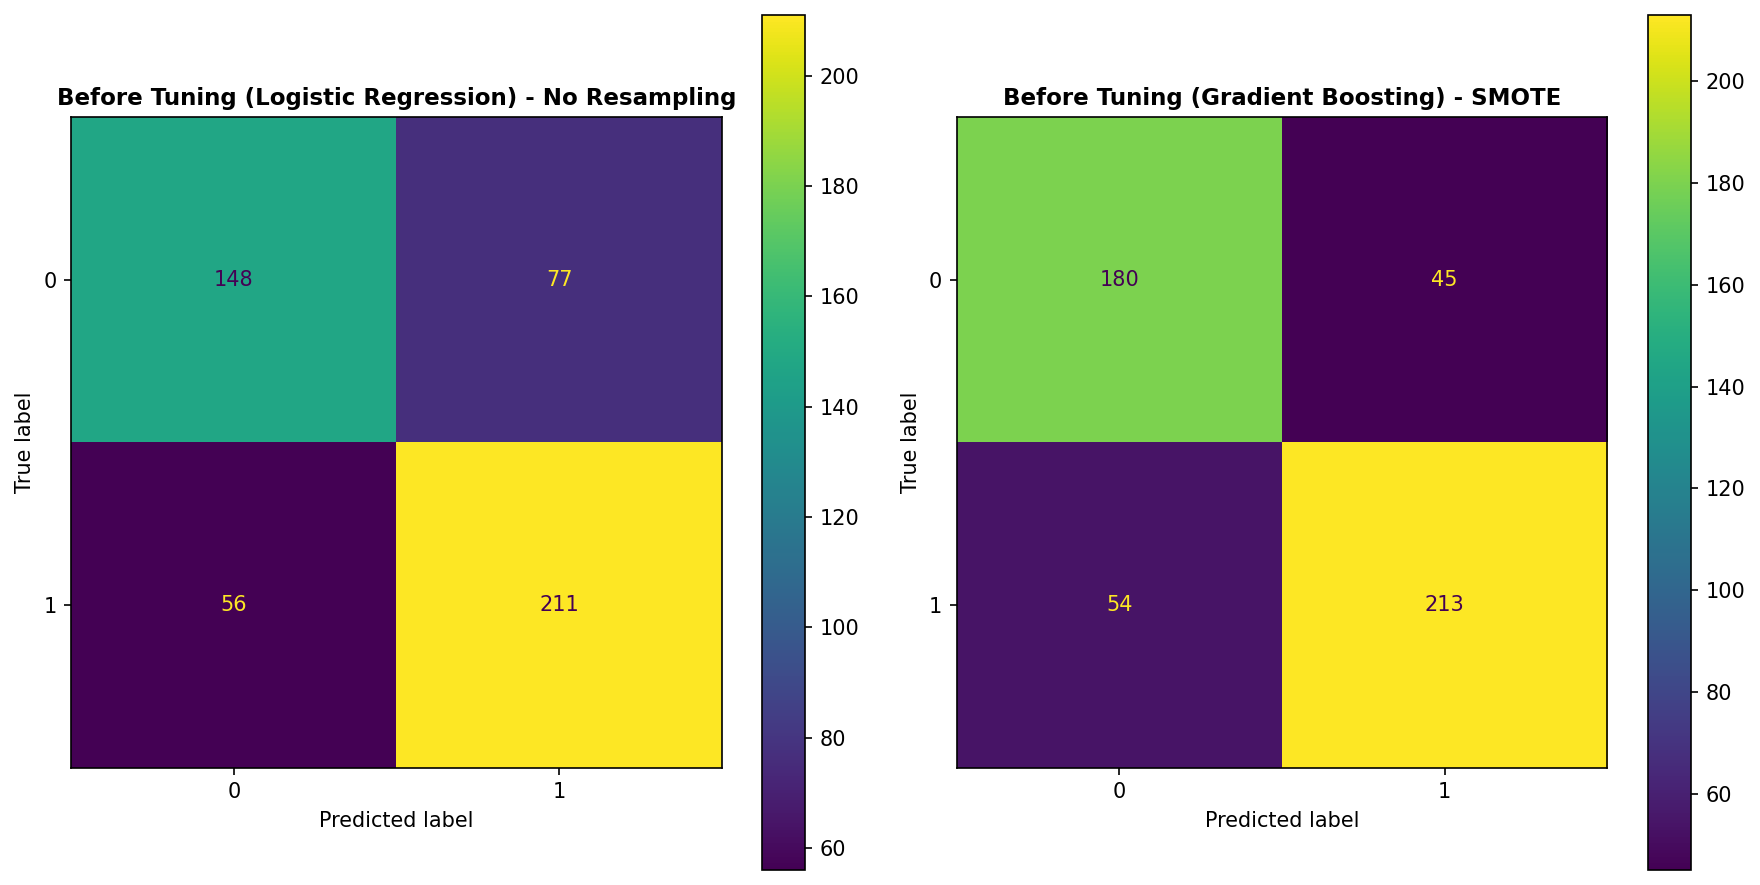

Benchmark Report
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       225
           1       0.73      0.79      0.76       267

    accuracy                           0.73       492
   macro avg       0.73      0.72      0.73       492
weighted avg       0.73      0.73      0.73       492

F2 score: 0.778

Benchmark w/ Resampling Report
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       225
           1       0.83      0.80      0.81       267

    accuracy                           0.80       492
   macro avg       0.80      0.80      0.80       492
weighted avg       0.80      0.80      0.80       492

F2 score: 0.803


In [342]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=150)

cm_bench = confusion_matrix(y_test, y_pred_bench)
cm_bench_sampling = confusion_matrix(y_test, y_pred_bench_sampling)

# Confusion matrix before resampling
disp_bench = ConfusionMatrixDisplay(confusion_matrix=cm_bench)
disp_bench.plot(ax=axes[0])
axes[0].set_title('Before Tuning (Logistic Regression) - No Resampling', fontdict={'fontsize': 11, 'fontweight': 'bold'})
axes[0].grid(False)

# Confusion matrix after ROS resampling
disp_bench_sampling = ConfusionMatrixDisplay(confusion_matrix=cm_bench_sampling)
disp_bench_sampling.plot(ax=axes[1])
axes[1].set_title('Before Tuning (Gradient Boosting) - SMOTE', fontdict={'fontsize': 11, 'fontweight': 'bold'})
axes[1].grid(False)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

print("Benchmark Report")
print(classification_report(y_test, y_pred_bench))
print("F2 score:", fbeta_score(y_test, y_pred_bench, beta=2).round(3))
print()
print("==========================================================================")
print("Benchmark w/ Resampling Report")
print(classification_report(y_test, y_pred_bench_sampling))
print("F2 score:", fbeta_score(y_test, y_pred_bench_sampling, beta=2).round(3))

We compared **Logistic Regression w/o resampling** vs **Gradient Boosting with SMOTE**. Results showed:

* **No Resampling (Logistic Regression):**<br>
  F2 Score = **0.778**<br>
  Slightly lower recall and more false negatives

* **With Resampling (Gradient Boost + SMOTE):**<br>
  F2 Score = **0.803** (higher)<br>
  Improved recall and better balance in false positives/negatives

Since **recall is critical** in churn prediction and **false positives are acceptable**, we decided to move forward with **Gradient Boost + SMOTE** for final model tuning and evaluation.

### **Tuning**

As we are moving forward by utlizing Gradient Boost, there are some parameters that we have to tune, which are:

| **Parameter**           | **Data Type**       | **Description**                                                                                                                              |
| ----------------------- | ------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| **n\_estimators**       | int                 | Number of boosting stages (trees).<br>- **Higher** values improve performance but increase computation time.                                 |
| **max\_depth**          | int                 | Maximum depth of individual trees.<br>- **Lower** values reduce overfitting.<br>- Useful for regularization.                                 |
| **min\_samples\_split** | int                 | Minimum number of samples required to split an internal node.<br>- Larger values make the model more conservative.                           |
| **min\_samples\_leaf**  | int                 | Minimum number of samples required at a leaf node.<br>- Prevents very small leaf nodes which can cause overfitting.                          |
| **max\_features**       | str, float, or None | Number of features to consider at each split:<br>- `'sqrt'` (default), `0.5` (50% of features), or `None` (use all). Affects tree diversity. |
| **subsample**           | float               | Fraction of samples used for fitting each base learner.<br>- **Lower (<1.0)** adds randomness → reduces overfitting.                         |
| **learning\_rate**      | float               | Shrinks contribution of each tree.<br>- **Smaller values** need more estimators but improve generalization.                                  |

In [343]:
pipe_prep_model = ImbPipe([
  ('transformer', transformer),
  ('feature_selection', SelectFromModel(GradientBoostingClassifier(n_estimators=100, random_state=42))),  # Auto-selects important features
  ('resampling', smote),
  ('modeling', gradient),
])


In [344]:
pgrid = {
  'transformer__pipe_simple_robust__imputer': [
    SimpleImputer(strategy='median'),
    KNNImputer()
  ],

  'feature_selection': [
    'passthrough',
    SelectFromModel(GradientBoostingClassifier(n_estimators=100, random_state=42))
  ],

  'resampling': [
    FunctionTransformer(validate=False),
    SMOTE(sampling_strategy='minority', random_state=42)
  ],

  'modeling__n_estimators': [400, 600, 800],
  'modeling__learning_rate': [0.005, 0.007, 0.01],
  'modeling__max_depth': [3, 4, 5],
  'modeling__min_samples_split': [6, 8],
  'modeling__min_samples_leaf': [5, 7, 10],
  'modeling__max_features': [0.3, 0.4, 'sqrt'],
  'modeling__subsample': [0.6, 0.7],
}

In [345]:
try:
  cv_result = pickle.load(open('models/best_cv_result.pkl', 'rb'))
  print("Running with pickled model")
except:
  # cv_result = GridSearchCV(
  #   estimator=pipe_prep_model,
  #   cv=5,
  #   scoring=f2_score,
  #   n_jobs=-1,
  #   param_grid=pgrid,
  # )

  cv_result = RandomizedSearchCV(
    estimator=pipe_prep_model,
    cv=5,
    scoring=f2_score,
    n_jobs=-1,
    param_distributions=pgrid,
    n_iter=50,
    random_state=0,
  	error_score='raise', 
    verbose=2
  )

  cv_result.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [346]:
tuned_model = cv_result.best_estimator_

tuned_model.fit(X_train, y_train)

y_pred_tuned = tuned_model.predict(X_test)

print('Best Params:', cv_result.best_params_)
print('Best Score:', round(cv_result.best_score_*100, 4))
print('Test Score:', round(fbeta_score(y_test, y_pred_tuned, beta=2)*100, 4))

Best Params: {'transformer__pipe_simple_robust__imputer': KNNImputer(), 'resampling': FunctionTransformer(), 'modeling__subsample': 0.6, 'modeling__n_estimators': 400, 'modeling__min_samples_split': 8, 'modeling__min_samples_leaf': 5, 'modeling__max_features': 0.4, 'modeling__max_depth': 5, 'modeling__learning_rate': 0.005, 'feature_selection': 'passthrough'}
Best Score: 79.0158
Test Score: 79.5287


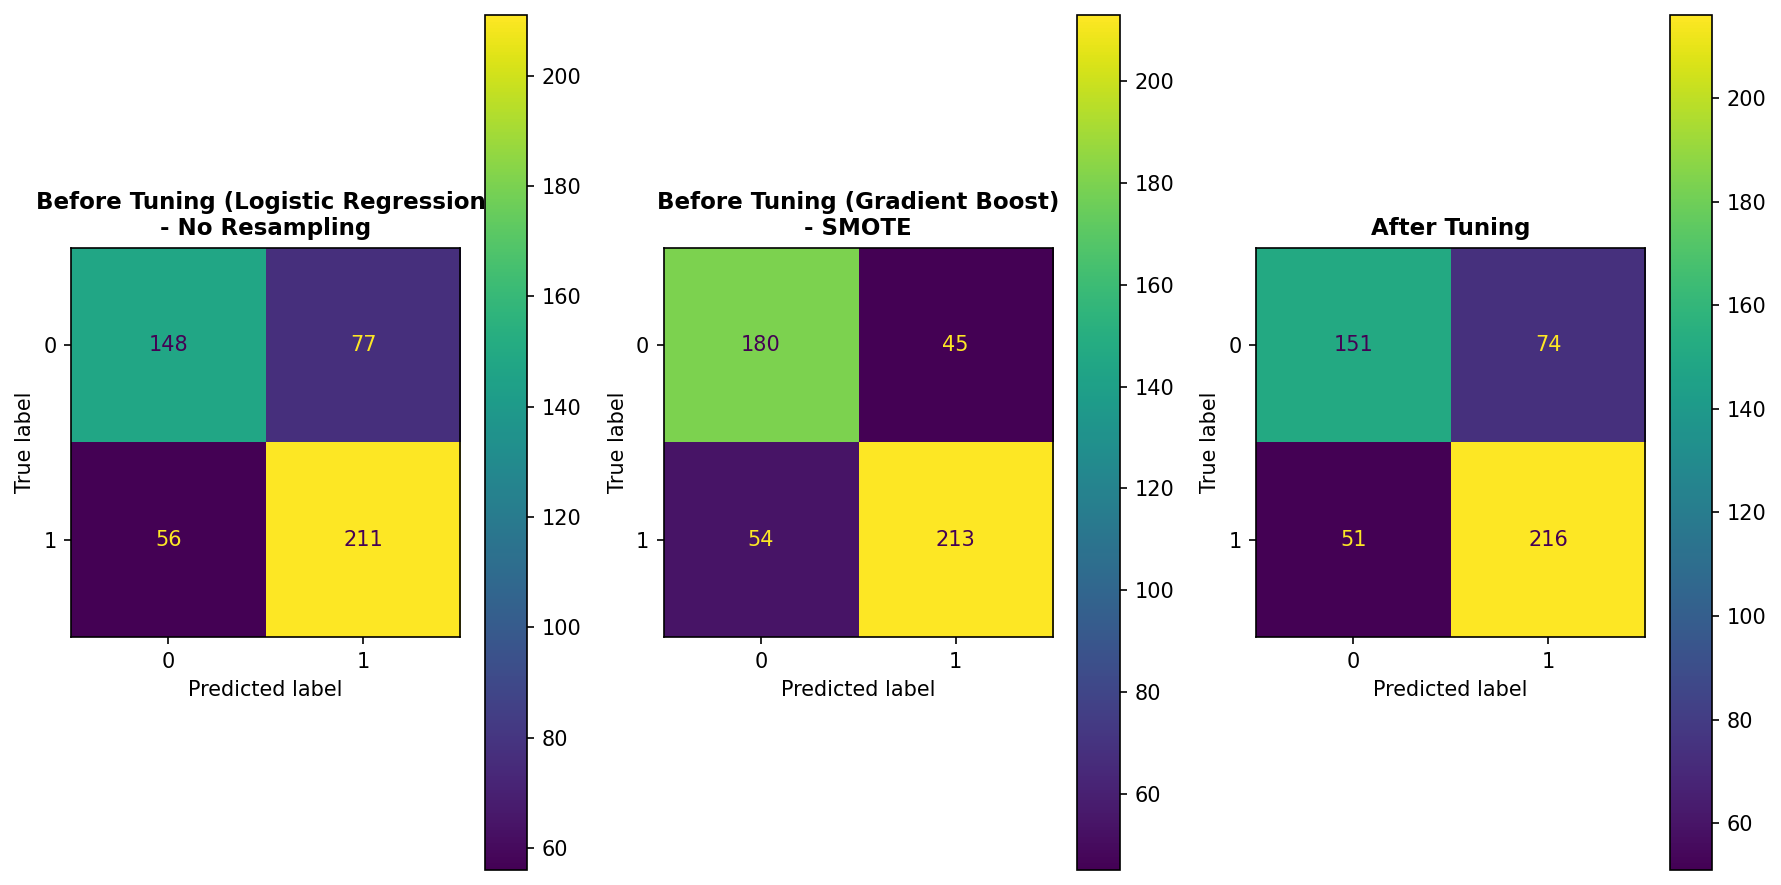

In [347]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), dpi=150)

cm_bench = confusion_matrix(y_test, y_pred_bench)
cm_bench_sampling = confusion_matrix(y_test, y_pred_bench_sampling)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

disp_bench = ConfusionMatrixDisplay(confusion_matrix=cm_bench)
disp_bench.plot(ax=axes[0])
axes[0].set_title('Before Tuning (Logistic Regression)\n- No Resampling', fontdict={'fontsize': 11, 'fontweight': 'bold'})
axes[0].grid(False)

disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_bench_sampling)
disp_tuned.plot(ax=axes[1])
axes[1].set_title('Before Tuning (Gradient Boost)\n- SMOTE', fontdict={'fontsize': 11, 'fontweight': 'bold'})
axes[1].grid(False)

disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned)
disp_tuned.plot(ax=axes[2])
axes[2].set_title('After Tuning', fontdict={'fontsize': 11, 'fontweight': 'bold'})
axes[2].grid(False)

plt.tight_layout()
plt.show()

After several tuning rounds, false positives could not be reduced further without hurting recall. The final Gradient Boosting model (without SMOTE) achieved a **79.53% F2 score** with:

* **216 true positives** (correctly identified churners)
* **74 false positives** (retention offered to non-churners)
* **51 false negatives** (missed churners)

#### **Business Impact (Assumptions)**

* Churn loss = R\$1,000 per seller
* Retention cost = R\$100 per seller

**Estimated results:**

* Intervention cost: 290 × R\$100 = R\$29,000
* Prevented churn loss: 216 × R\$1,000 = R\$216,000
* Unprevented loss: 51 × R\$1,000 = R\$51,000
* **Net savings: R\$136,000**

This confirms the model’s effectiveness in reducing churn loss with controlled cost.


#### **Pickling the Model**

In [348]:
try:
  pickle.dump(cv_result, open('models/best_cv_result.pkl', 'wb'))
except:
  pass

### **Feature Importance**

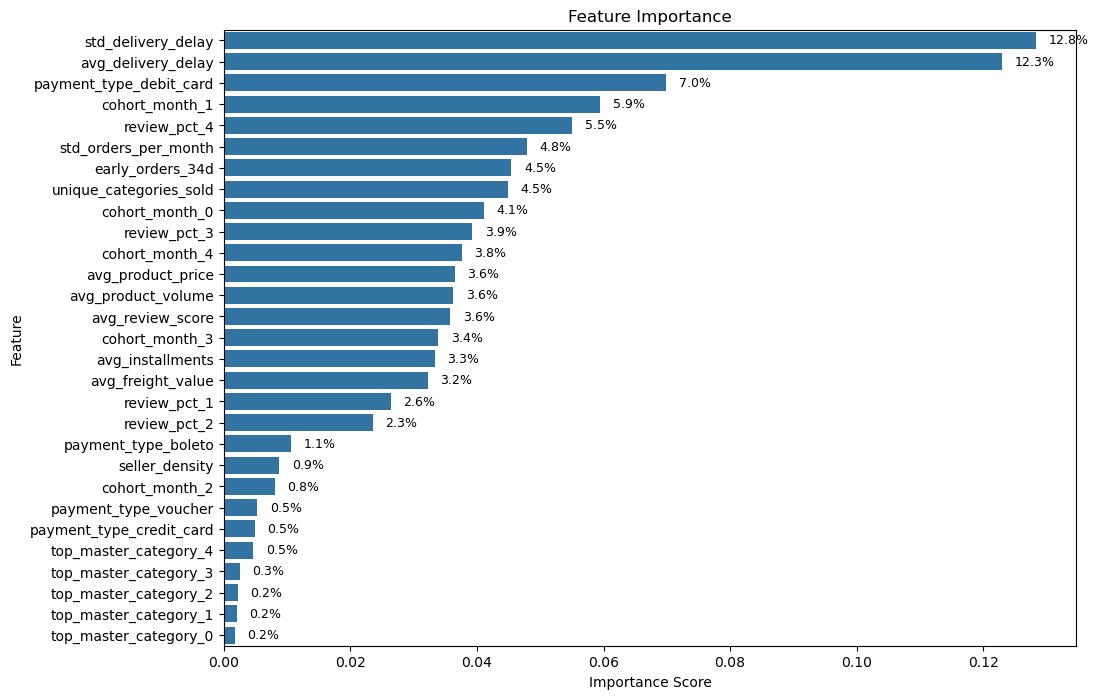

In [349]:
feature_names = [f.split('__')[-1] for f in list(tuned_model['transformer'].get_feature_names_out())]

fimp_df = pd.DataFrame({
  'Feature Importance': tuned_model['modeling'].feature_importances_
}, index=feature_names).sort_values('Feature Importance', ascending=False)

plt.figure(figsize=(11, 8))
ax = sns.barplot(data=fimp_df, x='Feature Importance', y=fimp_df.index, orient='h')

for patch in ax.patches:
  width = patch.get_width()
  plt.text(
    x=width + 0.002,
    y=patch.get_y() + patch.get_height() / 2,
    s=f'{width * 100:.1f}%',
    ha='left', va='center',
    fontsize=9
  )

plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()

1. **Delivery performance dominates**
   * `std_delivery_delay` (12.8%) and `avg_delivery_delay` (12.3%) are the top features.
   * This confirms that sellers with **inconsistent or delayed deliveries** are more likely to churn — likely due to customer dissatisfaction or fulfillment challenges.

2. **Payment behavior shows moderate influence**
   * `payment_type_debit_card` (7.0%) stands out among payment types, suggesting that sellers whose customers frequently pay by debit card might belong to segments with different churn dynamics, such as lower-value or fast-turnover products.

3. **Cohort and early momentum are key lifecycle indicators**
   * `cohort_month_1` (5.9%), `cohort_month_0` (4.1%), and others signal that **when a seller joined** plays a meaningful role, possibly reflecting market seasonality or onboarding effectiveness.
   * `early_orders_34d` (4.5%) shows that **early sales activity** is critical for retention — sellers who fail to gain momentum early are at greater risk of disengaging.

4. **Reviews and order consistency matter**
   * `review_pct_4` (5.5%) and `review_pct_3` (3.9%) suggest that **average-to-good reviews** are more predictive of seller survival than extreme scores.
   * `std_orders_per_month` (4.8%) also indicates that **order consistency**, not just volume, is a churn signal.

5. **Product and pricing factors contribute moderately**
   * `avg_product_price` (3.6%) and `avg_product_volume` (3.6%) reflect a seller’s price point and product size, which may influence margins or shipping reliability.
   * `avg_freight_value` (3.2%) also shows some impact, likely tied to operational costs.

6. **Lower impact features**
   * Variables like `seller_density`, `payment_type_credit_card`, and `top_master_category_X` each contribute <1%, suggesting that **geography, credit-based buyers, or category alone** are weak individual predictors.

### **SHAP**

In [350]:
preprocessor = tuned_model.named_steps['transformer']
model = tuned_model.named_steps['modeling']

X_train_transformed = preprocessor.transform(X_train)
feature_names = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]

explainer = shap.TreeExplainer(model)
shap_values_raw = explainer.shap_values(X_train_transformed)

# If SHAP returns 3D array, convert to 2D (binary classification class 1)
if isinstance(shap_values_raw, list):
	shap_values = shap_values_raw[1]  # Standard output for class 1
elif shap_values_raw.ndim == 3:
	shap_values = shap_values_raw[..., 1]  # From (n_samples, n_features, n_classes) → (n_samples, n_features)
else:
	shap_values = shap_values_raw

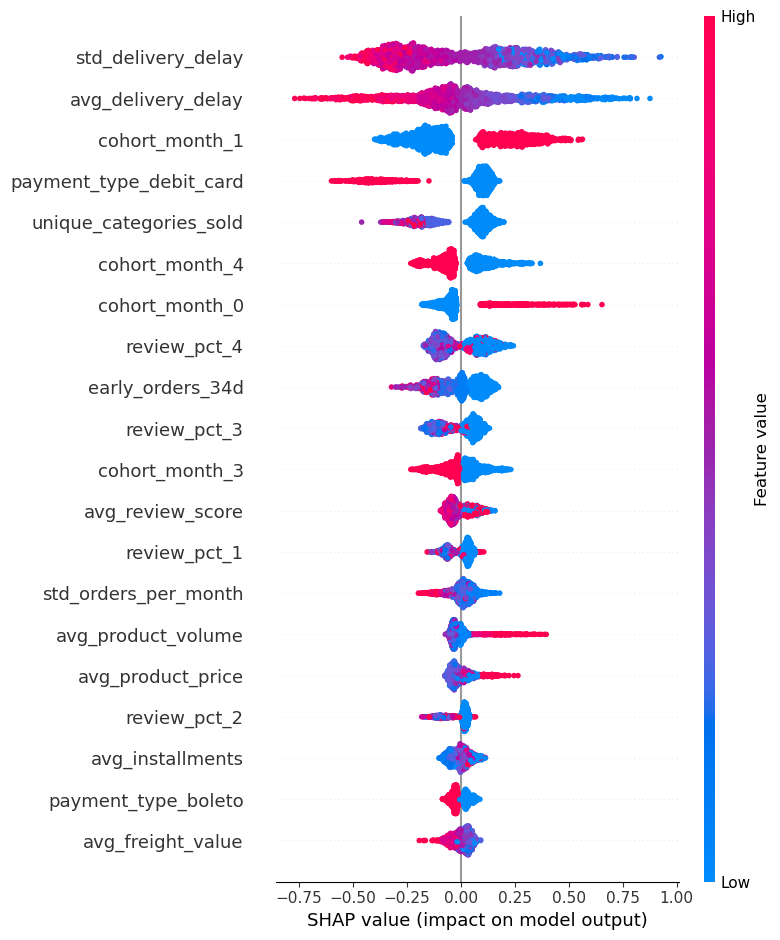

In [351]:
shap.summary_plot(
	shap_values,
	X_train_transformed,
	feature_names=feature_names
)

#### **1. Delivery Performance**
Sellers with **high delivery delays**—both in average and variability (`avg_delivery_delay`, `std_delivery_delay`)—show a strong positive SHAP impact toward churn. This confirms that **slow or inconsistent fulfillment** increases the likelihood of a seller leaving.

#### **2. Onboarding Cohorts**
Cohort timing has a clear effect. Sellers from `cohort_month_1` and `cohort_month_0` show higher SHAP values, suggesting they’re **more likely to churn** compared to others. This may reflect seasonal effects, onboarding quality, or broader market conditions at entry.

#### **3. Buyer Behavior**
Higher values in `payment_type_debit_card` correlate with churn—possibly indicating more price-sensitive customers or low-ticket sales. Similarly, `avg_freight_value` appears on the negative end, where **higher shipping costs** may discourage repeat purchases, indirectly impacting seller retention.

#### **4. Product Strategy**
Sellers with **higher category diversity** (`unique_categories_sold`) tend to stay, as do those with **early order momentum** (`early_orders_34d`). Both features show **negative SHAP values** when high, meaning they **reduce churn risk**.

#### **5. Review Patterns**
Mid-level review ratios (`review_pct_3`, `review_pct_4`) are influential. Sellers with more moderate feedback tend to have **higher churn probability**. These may reflect lack of strong customer advocacy or underwhelming performance.

#### **6. Pricing & Installments**
Sellers with **higher product prices**, volumes, or `avg_installments` trend toward higher churn, suggesting that **more expensive or complex orders** could make consistent sales harder to achieve.

## **> Conclusion & Recommendation**
<hr>

### **Conclusion**

Over the course of this project, we set out to **understand and predict seller churn** on the Olist platform using a combination of exploratory data analysis (EDA), feature engineering, and machine learning. Here's a summary of our key takeaways and final recommendations.

#### **Project Goal Recap**
The objective was to identify behavioral and operational patterns that lead to seller churn, then build a model that can **accurately predict which sellers are at risk**, enabling ***proactive retention*** strategies.

#### **Model Performance**

Using a **Gradient Boosting classifier (no resampling)**, the final tuned model achieved:

* **F2 Score (Test):** **79.53%** – optimized for **recall**, which is critical for proactive churn mitigation
* **F2 Score (CV):** \~**79.02%** – demonstrating strong generalization across validation folds
* **High recall** – the model captures most actual churners
* **Controlled false positives** – improved targeting efficiency without excessive outreach

This model provides strong practical value by flagging at-risk sellers early, allowing targeted retention strategies that reduce revenue loss and increase ROI.

#### **With or Without ML?**

**Assumptions:**

* Each seller generates **R\$1,000/month**
* Retention effort costs **R\$100/seller**
* **40% of contacted churners** are successfully retained

**Without the model:**

* All **267 churners** would be lost (216 TP + 51 FN)
* **Monthly loss = 267 × R\$1,000 = R\$267,000**

**With the model:**

* **216 churners identified (TP)** → 40% retained = **86 sellers**
* **Revenue saved = 86 × R\$1,000 = R\$86,000**
* **Churn loss = (267 - 86) × R\$1,000 = R\$181,000**
* **Intervention cost = (216 TP + 66 FP) × R\$100 = R\$28,200**

**Total cost with model = R\$181,000 + R\$28,200 = R\$209,200**

| Metric                      | Value (R\$) |
| --------------------------- | ----------- |
| Loss without model          | 267,000     |
| Loss with model             | 209,200     |
| Retention cost              | 28,200      |
| Revenue saved (retained)    | 86,000      |
| **Net savings using model** | **57,800**  |

#### **Churn Drivers (Insights from SHAP & Feature Importance)**

1. **Delivery Reliability** – High average and standard deviation in delivery delays are the most influential churn signals, reflecting fulfillment issues.
2. **Cohort Effects** – Sellers from specific onboarding cohorts (e.g. `cohort_month_1`, `0`) are more prone to churn, suggesting time-sensitive onboarding effectiveness.
3. **Early Engagement** – Sellers with early sales activity (`early_orders_34d`) are more likely to stay; a lack of momentum is a churn risk.
4. **Customer Feedback** – Moderate reviews (`review_pct_4`, `3`) and low average ratings increase churn likelihood, pointing to trust and satisfaction issues.
5. **Product Strategy** – Low product diversity and high reliance on certain payment types (e.g., debit card) correlate with increased churn risk.
6. **Pricing & Operational Factors** – Higher product prices, large order volumes, or high freight costs may reduce seller consistency and retention.

### **Recommendation**

**Retention Strategy**

* **Support early-stage sellers**: Prioritize onboarding and promotional support within the first 30–45 days — early momentum (`early_orders_34d`) is a key churn signal.
* **Track fulfillment and feedback KPIs**: Continuously monitor delivery reliability (`avg/std_delivery_delay`) and customer reviews (`review_pct_4`, `avg_review_score`) to detect decline before sellers disengage.
* **Segment by product and payment patterns**: Identify sellers in narrow or low-volume categories and adapt retention strategies (e.g., targeting those with high debit-card transactions or limited product diversity).
* **Listen to feedback**: Though data is not provided, it is always a good idea to listen from both customers & sellers feedback.

**Operational Actions**

* **Embed churn predictions in seller dashboards**: Highlight at-risk sellers for account managers using model outputs directly in management interfaces.
* **Integrate with CRM systems**: Use churn scores to trigger automated workflows — such as retention emails, personalized check-ins, or targeted offers.
* **Retrain quarterly**: Recalibrate the model every 3 months to account for changes in seasonality, seller behavior, or platform policies.

**Limitations & Future Work**

* **Feature limitations**: The current dataset lacks information on key drivers like **profit margins**, **seller tenure in months**, and **time spent active**. For example, the seller age range is from **1 to 32 months**, and product category features span **21 unique values** — some of which may be too sparse for stable inference.
* **Model design constraints**: The model avoids using any **future-derived features** (e.g., churn labels or activity post-label date). All features are constructed from **historical data available up to the cutoff point**, preventing data leakage.
* **External factors not included**: Reasons for churn such as **competition, personal motivation, or economic downturns** are not captured in the data. This limits the model’s ability to generalize outside behavioral patterns.
* **Model drift and decay**: Seller behavior may evolve due to policy changes or macro trends. Without ongoing monitoring, the model’s performance may decline. **Scheduled validation and retraining** are essential.
* **Hardware and tuning limits**: Hyperparameter tuning was constrained by limited computational resources. Additional performance gains may be possible with **larger search spaces and more parallelized grid searches**.